In [1]:


import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import seaborn as sns
import pickle
from tqdm import tqdm
import math
import os
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pickle

## Loading 2019 data

In [2]:
file= 'E:\CIT\MSc_AI\Research project_NIMBUS\Data\working_data\data_2019.csv'
data = pd.read_csv(file,infer_datetime_format=True,index_col=0)
data['applicable_date'] = pd.to_datetime(data['applicable_date'],format='%Y-%m-%d %H:%M:%S')
print(data.shape)
data.head()

(7416, 16)


,applicable_date,elec_prices,rain_d,temp_d,wdsp_d,wddir_d,rain_c,temp_c,wdsp_c,wddir_c,rain_g,temp_g,wdsp_g,wddir_g,daily_oil_price,daily_natural_gas
0,2019-01-01 00:00:00,70.28,0.0,8.8,4.626,250,0.0,8.5,2.056,240,0.0,9.9,2.056,260,59.41,2.62
1,2019-01-01 01:00:00,65.18,0.0,8.3,4.626,250,0.0,8.5,1.542,270,0.0,9.3,2.056,240,59.41,2.62
2,2019-01-01 02:00:00,60.91,0.0,8.4,4.112,240,0.0,8.4,1.542,280,0.0,9.2,2.570,240,59.41,2.62
3,2019-01-01 03:00:00,65.16,0.0,8.6,4.112,250,0.0,8.5,2.570,260,0.0,9.1,2.570,250,59.41,2.62
4,2019-01-01 04:00:00,65.16,0.0,8.4,5.140,250,0.0,8.5,2.570,270,0.0,8.8,2.056,250,59.41,2.62


In [3]:
data['applicable_date'].min(), data['applicable_date'].max(), (data['applicable_date'].max() - data['applicable_date'].min())

(Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-12-12 22:00:00'),
 Timedelta('345 days 22:00:00'))

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7416 entries, 0 to 7415
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   applicable_date    7416 non-null   datetime64[ns]
 1   elec_prices        7416 non-null   float64       
 2   rain_d             7416 non-null   float64       
 3   temp_d             7416 non-null   float64       
 4   wdsp_d             7416 non-null   float64       
 5   wddir_d            7416 non-null   int64         
 6   rain_c             7416 non-null   float64       
 7   temp_c             7416 non-null   float64       
 8   wdsp_c             7416 non-null   float64       
 9   wddir_c            7416 non-null   int64         
 10  rain_g             7416 non-null   float64       
 11  temp_g             7416 non-null   float64       
 12  wdsp_g             7416 non-null   float64       
 13  wddir_g            7416 non-null   int64         
 14  daily_oi

In [5]:
# Basic stats:
data.elec_prices.describe()

count    7416.000000
mean       49.535521
std        19.948698
min       -11.860000
25%        38.140000
50%        47.501000
75%        59.065000
max       145.840000
Name: elec_prices, dtype: float64

In [6]:
def plot_pdf(data,feature):
    import warnings 
    warnings.filterwarnings("ignore")

    sns.FacetGrid(data,size=5) \
       .map(sns.distplot,feature) \
       .add_legend()
    plt.xlabel(feature +" in €")
    plt.ylabel('PDF')
    plt.title("Probability distribution of "+feature)
    plt.grid()
    plt.show()

In [7]:
def scatter_plot(x,y,col_name):
    plt.figure(figsize=(15,6))
    plt.plot(x, y, 'o', color='blue')
    plt.title("Scatter plot of "+col_name)
    plt.xlabel("instances")
    plt.ylabel(col_name)

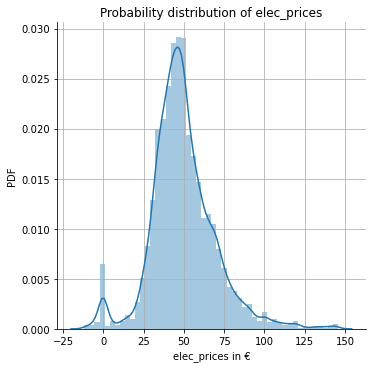

In [8]:
plot_pdf(data,'elec_prices')

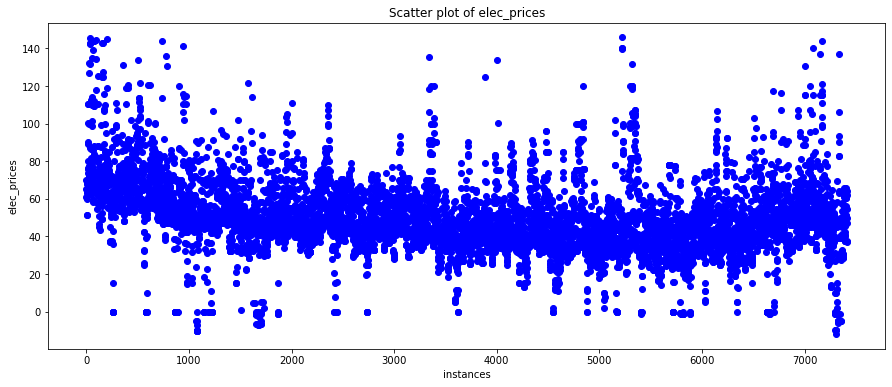

In [9]:
scatter_plot(range(data.shape[0]),data["elec_prices"].values,'elec_prices')

## Loading 2018-2019 data for testing

In [5]:
file= 'E:\CIT\MSc_AI\Research project_NIMBUS\Data\working_data\data_2018_19.csv'
data_1819 = pd.read_csv(file,infer_datetime_format=True,index_col=0)
data_1819['applicable_date'] = pd.to_datetime(data_1819['applicable_date'],format='%Y-%m-%d %H:%M:%S')
print(data_1819.shape)
data_1819.head()

(9686, 16)


,applicable_date,elec_prices,rain_d,temp_d,wdsp_d,wddir_d,rain_c,temp_c,wdsp_c,wddir_c,rain_g,temp_g,wdsp_g,wddir_g,daily_oil_price,daily_natural_gas
0,2018-09-30 23:00:00,71.267,0.0,5.4,5.140,280,0.0,8.1,3.598,320,0.0,3.9,1.542,290,78.89,2.79
1,2018-10-01 00:00:00,67.212,0.0,5.2,5.140,280,0.0,7.7,4.112,320,0.0,6.2,1.542,270,84.94,2.80
2,2018-10-01 01:00:00,60.500,0.0,5.2,5.654,280,0.0,7.4,3.084,320,0.0,7.2,2.056,270,84.94,2.80
3,2018-10-01 02:00:00,63.682,0.0,4.8,4.626,270,0.0,5.3,1.542,200,0.0,6.9,2.056,280,84.94,2.80
4,2018-10-01 03:00:00,71.617,0.0,4.6,3.084,260,0.0,6.5,1.542,290,0.0,7.2,2.056,280,84.94,2.80


In [6]:
data_1819['applicable_date'].min(), data_1819['applicable_date'].max(), (data_1819['applicable_date'].max() - data_1819['applicable_date'].min())

(Timestamp('2018-09-30 23:00:00'),
 Timestamp('2019-12-12 22:00:00'),
 Timedelta('437 days 23:00:00'))

### Function to normalize data

In [7]:
def normalize(x_train,x_test):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler().fit(x_train)
    x_train_norm = scaler.transform(x_train)
    x_test_norm = scaler.transform(x_test)
    return x_train_norm,x_test_norm

### Evaluation metrics

In [8]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100
def eval_metrics(y_true,y_pred):
    MAE = mean_absolute_error(y_true,y_pred)
    MSE = mean_squared_error(y_true,y_pred)
    RMSE = mean_squared_error(y_true,y_pred,squared=False)
    MAPE = mean_absolute_percentage_error(y_true,y_pred)
    R2 = r2_score(y_true, y_pred)
    print("MAE: ",round((MAE),4))
    print("MSE: ",round((MSE),4))
    print("RMSE: ",round((RMSE),4))
    print("MAPE: ",round((MAPE),4))
    print("Coefficient of determination (R-squared): ",round((R2),4))
    print('\n')
    return MAE,MSE,RMSE,MAPE,R2

### Function to convert single time step target to multiple(24) time steps

In [9]:
def multi_step(data,target):

    for time_step in range(1,24):
        name = 't'+'+'+str(time_step)
        data[name] = data[target].shift(-time_step)

    return data

### Function to create lags for features

In [10]:
def calc_24lags(data,feature):
    if feature == 'elec_prices':
        for time_step in range(1,25):
            name = 'lag_'+str(time_step)+'_'+feature
            data[name] = data[feature].shift(time_step).bfill(axis ='rows')
    else:
        for time_step in range(1,24):
            name = 'lag_'+str(time_step)+'_'+feature
            data[name] = data[feature].shift(time_step).bfill(axis ='rows')
            
    return data

### Function to remove 23 rows per day

In [11]:
def remove_23rows_hour_col(data):
    data = data[data['Hour']==23]
    data= data.drop(['Hour'], axis=1)
    data = data.reset_index(drop=True)
    print(data.shape)
    return data

### Function to perform time based splitting

In [12]:
#80-20split
def train_test_split_tbs(final_data):
    train,test = final_data.iloc[:int(0.8*final_data.shape[0]), :] , final_data.iloc[int(0.8*final_data.shape[0]):, :]
    print(train.shape)
    print(test.shape)
    
    return train,test

### Functions of Boosting models

#### GBM

In [13]:
def GBM_training(X,y):

    start_time = datetime.now()

    wrapper1 = MultiOutputRegressor(
        GradientBoostingRegressor(max_features='sqrt', random_state=100))

    hyperparameters = {'estimator__learning_rate':[0.1,0.05,0.025,0.0125],
                       'estimator__n_estimators':range(20,101,10),
                       'estimator__max_depth':range(5,14,2),
                       'estimator__min_samples_split':range(100,501,100),
                       'estimator__max_features':range(1,7,1),
                       'estimator__min_samples_leaf':range(10,61,10),
                       'estimator__subsample': [0.5,0.6,0.7,0.75,0.8,0.85,0.9]}

    rsearch = RandomizedSearchCV(
        estimator = wrapper1, param_distributions = hyperparameters,
        scoring='neg_mean_absolute_error',n_jobs = -1, cv=10,
        return_train_score=True)

    rsearch.fit(X,y)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    print("\n\n")
    print(rsearch.cv_results_)
    print(rsearch.best_params_)
    print(rsearch.best_score_)


In [14]:
def GBM_model(X,y,learning_rate,n_estimators,max_depth,min_samples_split,max_features,min_samples_leaf,subsample):
    
    learning_rate=learning_rate
    n_estimators=n_estimators
    max_depth= max_depth
    min_samples_split= min_samples_split
    max_features= max_features
    min_samples_leaf= min_samples_leaf
    subsample= subsample

    start_time = datetime.now()

    GBM = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, 
                                                         max_depth= max_depth,min_samples_split= min_samples_split,
                                                         max_features= max_features, min_samples_leaf= min_samples_leaf,
                                                         subsample= subsample, random_state=100))

    GBM.fit(X,y)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))

    return GBM

#### XGBM

In [15]:
def XGBM_training(X,y):

    start_time = datetime.now()

    wrapper = MultiOutputRegressor(XGBRegressor(n_jobs = -1))

    hyperparameters = {'estimator__learning_rate':[0.2,0.1,0.05,0.025,0.0125],
                       'estimator__n_estimators':range(50, 500, 50),
                       'estimator__max_depth':range(3,14,2),
                       'estimator__subsample':np.arange(0.1, 1.1, 0.1),
                           'estimator__colsample_bytree':np.arange(0.1, 1.1, 0.1)}

    rsearch = RandomizedSearchCV(
        estimator = wrapper, param_distributions = hyperparameters,
        scoring='neg_mean_absolute_error',
        n_jobs = -1, cv=10, return_train_score=True)

    rsearch.fit(X,y)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    print("\n\n")
    print(rsearch.cv_results_)
    print(rsearch.best_params_)
    print(rsearch.best_score_)

In [16]:
def XGBM_model(X,y,learning_rate,n_estimators,max_depth,subsample,colsample_bytree):

    learning_rate = learning_rate
    n_estimators = n_estimators
    max_depth = max_depth
    subsample = subsample
    colsample_bytree = colsample_bytree

    start_time = datetime.now()

    XGBM = MultiOutputRegressor(XGBRegressor(learning_rate=learning_rate, n_estimators=n_estimators, max_depth= max_depth,
                                            subsample= subsample, colsample_bytree = colsample_bytree, random_state=100))

    XGBM.fit(X,y)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))

    return XGBM

#### LGBM

In [17]:
def LGBM_training(X,y):

    start_time = datetime.now()

    wrapper = MultiOutputRegressor(LGBMRegressor(random_state=100, n_jobs = -1))

    hyperparameters = {'estimator__learning_rate':[0.2,0.1,0.05,0.025,0.0125],
                       'estimator__n_estimators':range(50, 501, 50),
                       'estimator__max_depth':range(3,14,2),
                       'estimator__subsample':np.arange(0.1, 1.1, 0.1),
                       'estimator__colsample_bytree':np.arange(0.1, 1.1, 0.1),
                       'estimator__num_leaves':[round(0.6*2**x) for x in range(3,14,2)],
                      'estimator__min_child_samples ':range(10,71,10)}

    rsearch = RandomizedSearchCV(
        estimator = wrapper, param_distributions = hyperparameters,
        scoring='neg_mean_absolute_error',
        n_jobs = -1, cv=10, return_train_score=True)

    rsearch.fit(X,y)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    print("\n\n")
    print(rsearch.cv_results_)
    print(rsearch.best_params_)
    print(rsearch.best_score_)

In [18]:
def LGBM_model(X,y,num_leaves,min_child_samples,learning_rate,n_estimators,max_depth,subsample,colsample_bytree):

    num_leaves = num_leaves
    min_child_samples = min_child_samples
    learning_rate = learning_rate
    n_estimators = n_estimators
    max_depth= max_depth
    subsample= subsample
    colsample_bytree = colsample_bytree

    start_time = datetime.now()

    LGB = MultiOutputRegressor(LGBMRegressor(num_leaves=num_leaves,min_child_samples = min_child_samples,learning_rate=learning_rate,n_estimators=n_estimators,
                                               max_depth= max_depth,subsample= subsample,colsample_bytree = colsample_bytree,random_state=100,
                                               n_jobs = -1))

    LGB.fit(X,y)

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    
    return LGB

### Rndomized splitting for testing

In [19]:
def random_splitting(data):
    from sklearn.model_selection import train_test_split
    X= data[x_names]; y= data[y_names]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)
    print(X_train.shape,X_val.shape,X_test.shape)
    print(y_train.shape,y_val.shape,y_test.shape)
    
    return X_train,X_val,X_test,y_train,y_val, y_test

### Testing iterations/runs

In [20]:
def testing_runs(n,data,model):
    mae = []; mse = []; rmse = []; mape = []; r2 = []
    for i in range(n):
        print("Round {}: ".format(i+1))
        X_train,X_val,X_test,y_train,y_val, y_test = random_splitting(data)
        x_train_norm,x_test_norm = normalize(X_train,X_test)
        y_pred= model.predict(x_test_norm)
        MAE,MSE,RMSE,MAPE,R2 = eval_metrics(y_test,y_pred)
        mae.append(round((MAE),4))
        mse.append(round(MSE,4))
        rmse.append(round(RMSE,4))
        mape.append(round(MAPE,4))
        r2.append(round(R2,4))
    print("Average MAE: ",round(np.mean(mae),4))
    print("Average MSE: ",round(np.mean(mse),4))
    print("Average RMSE: ", round(np.mean(rmse),4))
    print("Average MAPE: ", round(np.mean(mape),4))
    print("Average R2: ", round(np.mean(r2),4))
    
    return mae,mse,rmse,mape,r2

<h1 style="text-align:center;font-size:40px;" > Basic time based features </h1>

In [21]:
def feature_pipeline_1(basic_time):

    basic_time= basic_time[['applicable_date','elec_prices']]
    basic_time['month']=basic_time['applicable_date'].dt.month
    basic_time['dayofyear_num']=basic_time['applicable_date'].dt.dayofyear
    basic_time['weekofyear_num']=basic_time['applicable_date'].dt.weekofyear
    basic_time['Hour'] = basic_time['applicable_date'].dt.hour
    #basic_time['expanding_window_price'] = basic_time['elec_prices'].expanding().mean()
    return basic_time

In [20]:
basic_time= data.copy()
basic_time = feature_pipeline_1(basic_time)
basic_time.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour
0,2019-01-01 00:00:00,70.28,1,1,1,0
1,2019-01-01 01:00:00,65.18,1,1,1,1
2,2019-01-01 02:00:00,60.91,1,1,1,2
3,2019-01-01 03:00:00,65.16,1,1,1,3
4,2019-01-01 04:00:00,65.16,1,1,1,4


In [21]:
basic_time = multi_step(basic_time,'elec_prices')
basic_time.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,t+1,t+2,t+3,t+4,...,t+14,t+15,t+16,t+17,t+18,t+19,t+20,t+21,t+22,t+23
0,2019-01-01 00:00:00,70.28,1,1,1,0,65.18,60.91,65.160,65.160,...,100.278,110.33,90.000,66.000,89.000,76.090,76.205,73.664,71.38,71.38
1,2019-01-01 01:00:00,65.18,1,1,1,1,60.91,65.16,65.160,68.290,...,110.330,90.00,66.000,89.000,76.090,76.205,73.664,71.380,71.38,66.98
2,2019-01-01 02:00:00,60.91,1,1,1,2,65.16,65.16,68.290,63.030,...,90.000,66.00,89.000,76.090,76.205,73.664,71.380,71.380,66.98,71.38
3,2019-01-01 03:00:00,65.16,1,1,1,3,65.16,68.29,63.030,51.621,...,66.000,89.00,76.090,76.205,73.664,71.380,71.380,66.980,71.38,71.38
4,2019-01-01 04:00:00,65.16,1,1,1,4,68.29,63.03,51.621,51.632,...,89.000,76.09,76.205,73.664,71.380,71.380,66.980,71.380,71.38,75.00


In [22]:
basic_time = calc_24lags(basic_time,'elec_prices')
print(basic_time.shape)
print(basic_time.columns)
basic_time.head()

(7416, 53)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices'],
      dtype='object')


,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,t+1,t+2,t+3,t+4,...,lag_15_elec_prices,lag_16_elec_prices,lag_17_elec_prices,lag_18_elec_prices,lag_19_elec_prices,lag_20_elec_prices,lag_21_elec_prices,lag_22_elec_prices,lag_23_elec_prices,lag_24_elec_prices
0,2019-01-01 00:00:00,70.28,1,1,1,0,65.18,60.91,65.160,65.160,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28
1,2019-01-01 01:00:00,65.18,1,1,1,1,60.91,65.16,65.160,68.290,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28
2,2019-01-01 02:00:00,60.91,1,1,1,2,65.16,65.16,68.290,63.030,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28
3,2019-01-01 03:00:00,65.16,1,1,1,3,65.16,68.29,63.030,51.621,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28
4,2019-01-01 04:00:00,65.16,1,1,1,4,68.29,63.03,51.621,51.632,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28


In [23]:
#Dropping rows with Nan's
basic_time = basic_time.dropna(axis=0)
print(basic_time.shape)

(7393, 53)


In [24]:
basic_time.isnull().values.any()

False

In [25]:
basic_time = remove_23rows_hour_col(basic_time)

(310, 52)


In [26]:
basic_time.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,t+1,t+2,t+3,t+4,t+5,...,lag_15_elec_prices,lag_16_elec_prices,lag_17_elec_prices,lag_18_elec_prices,lag_19_elec_prices,lag_20_elec_prices,lag_21_elec_prices,lag_22_elec_prices,lag_23_elec_prices,lag_24_elec_prices
0,2019-01-01 23:00:00,76.09,1,1,1,76.205,73.664,71.380,71.380,66.98,...,65.160,65.160,60.91,65.180,70.280,70.28,70.28,70.280,70.28,70.28
1,2019-01-02 23:00:00,71.01,1,2,1,70.720,66.720,66.720,62.720,62.72,...,66.980,71.380,71.38,73.664,76.205,76.09,89.00,66.000,90.00,110.33
2,2019-01-03 23:00:00,72.69,1,3,1,68.690,69.000,59.286,59.195,58.40,...,62.720,62.720,62.72,66.720,66.720,70.72,71.01,77.520,76.98,87.00
3,2019-01-04 23:00:00,82.99,1,4,1,72.570,72.570,72.570,72.570,67.56,...,59.195,59.286,69.00,68.690,72.690,77.68,77.04,81.439,135.00,114.00
4,2019-01-05 23:00:00,72.95,1,5,1,72.950,65.582,62.074,68.380,72.95,...,69.000,67.560,72.57,72.570,72.570,72.57,82.99,83.860,80.28,109.48


In [27]:
train,test = train_test_split_tbs(basic_time)

(248, 52)
(62, 52)


In [28]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:5]
lags = cols[-24:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[5:28]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23']


In [29]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 27) (248, 24)
(62, 27) (62, 24)


In [30]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [31]:
x_train_norm[0]

array([0.        , 0.        , 0.        , 0.61662533, 0.75340416,
       0.64133244, 0.71448571, 0.62090154, 0.72479402, 0.47054931,
       0.34777987, 0.40540765, 0.46197551, 0.24166104, 0.23654545,
       0.33127715, 0.35288718, 0.46581014, 0.5694343 , 0.77318801,
       0.89894466, 0.9312924 , 0.83338736, 0.77372768, 0.73425617,
       0.55365517, 0.50410489])

In [32]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:15.655388



{'mean_fit_time': array([1.52496755, 1.50096209, 1.50074334, 1.52377992, 1.66835034,
       1.54592559, 0.98391957, 1.47302208, 0.50653095, 0.99297543]), 'std_fit_time': array([0.02609801, 0.03040367, 0.03199074, 0.02635574, 0.01698622,
       0.0290136 , 0.04331818, 0.04787527, 0.01164186, 0.06480385]), 'mean_score_time': array([0.01600142, 0.0160018 , 0.01693969, 0.01680391, 0.01840372,
       0.01600223, 0.01600204, 0.02031443, 0.01878865, 0.00880096]), 'std_score_time': array([1.96257740e-06, 1.07790514e-06, 2.39089418e-03, 2.39994829e-03,
       3.66545420e-03, 9.15974269e-07, 3.57675667e-03, 7.16051916e-03,
       6.23262876e-03, 4.30965243e-03]), 'param_estimator__subsample': masked_array(data=[0.85, 0.9, 0.9, 0.9, 0.75, 0.75, 0.7, 0.85, 0.8, 0.9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(d

In [33]:
gbm1 = GBM_model(x_train_norm,y_train,0.05,70,7,100,5,10,0.75)

Duration: 0:00:01.056692


gbm1 = GBM_model(x_train_norm,y_train,0.05,40,11,100,3,20,0.75)

In [34]:
y_pred= gbm1.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.932230877539476
MSE:  232.1602875205659
RMSE:  15.236806998861864
MAPE:  22.756970246380348
Coefficient of determination (R-squared):  -0.004179449954366005




(10.932230877539476,
 232.1602875205659,
 15.236806998861864,
 22.756970246380348,
 -0.004179449954366005)

In [76]:
#ignore
y_pred= gbm1.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.336479935867416
MSE:  219.23085211778678
RMSE:  14.806446302802938
MAPE:  21.516831192810017
Coefficient of determination (R-squared):  0.05940901220700426


### XGBoost

In [35]:
XGBM_training(x_train_norm,y_train)

Duration: 0:01:25.925207



{'mean_fit_time': array([14.17287877,  3.98656099, 11.18186049, 13.38342886,  5.64627752,
        4.41017344,  7.87481372,  8.68060169,  2.72580283, 18.27810171]), 'std_fit_time': array([0.19342234, 3.50499324, 0.3684555 , 0.4646692 , 0.22707205,
       0.1215253 , 0.10722713, 0.41953613, 0.12721443, 0.25970529]), 'mean_score_time': array([0.04023976, 0.03622704, 0.05767658, 0.05002615, 0.05694377,
       0.05520568, 0.04612393, 0.04446692, 0.03360326, 0.05099547]), 'std_score_time': array([0.0046885 , 0.00915516, 0.01469309, 0.0044986 , 0.00430205,
       0.00976654, 0.00317032, 0.00808966, 0.0048003 , 0.01129381]), 'param_estimator__subsample': masked_array(data=[0.7000000000000001, 0.6, 0.30000000000000004, 0.9, 0.2,
                   0.1, 0.4, 0.8, 0.4, 0.8],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': maske

In [36]:
xgb1 = XGBM_model(x_train_norm,y_train,0.0125,450,9,0.1,0.3)
#xgb1 = XGBM_model(x_train_norm,y_train,0.025,350,11,0.1,0.4)

Duration: 0:00:03.299215


In [37]:
y_pred= xgb1.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.536125717901413
MSE:  247.31707413391777
RMSE:  15.726317882260862
MAPE:  24.014061966085446
Coefficient of determination (R-squared):  -0.0692034570641029




(11.536125717901413,
 247.31707413391777,
 15.726317882260862,
 24.014061966085446,
 -0.0692034570641029)

In [196]:
#ignore
y_pred= xgb1.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.730868587308676
MSE:  252.73370229794895
RMSE:  15.897600520139791
MAPE:  24.419446533466
Coefficient of determination (R-squared):  -0.1013240139523583




(11.730868587308676,
 252.73370229794895,
 15.897600520139791,
 24.419446533466,
 -0.1013240139523583)

### Light GBM

In [38]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 30
Duration: 0:00:25.362292



{'mean_fit_time': array([0.78972092, 4.28605893, 4.03607674, 1.68674786, 2.82147052,
       1.86715345, 2.8385957 , 0.48347154, 2.62755809, 2.97704699]), 'std_fit_time': array([0.06870739, 0.14517481, 0.33113478, 0.14603741, 0.08725945,
       0.11693747, 0.09426693, 0.0226031 , 0.12965719, 0.31360855]), 'mean_score_time': array([0.01269939, 0.050245  , 0.04836793, 0.02313318, 0.04459836,
       0.0277132 , 0.03247719, 0.01087286, 0.05083389, 0.01656682]), 'std_score_time': array([0.00637685, 0.0138037 , 0.01140042, 0.0046071 , 0.00774892,
       0.00808909, 0.00439883, 0.00712616, 0.01089106, 0.00667763]), 'param_estimator__subsample': masked_array(data=[0.7000000000000001, 0.4, 0.6, 0.30000000000000004, 0.2,
                   0.30000000000000004, 1.0, 1.0, 0.2, 0.9],
             mask=[False, 

In [39]:
#def LGBM_model(X,y,num_leaves,min_child_samples,learning_rate,n_estimators,max_depth,subsample,colsample_bytree)
lgbm1 = LGBM_model(x_train_norm,y_train,307,30,0.0125,350,5,0.2,0.2)
#lgbm1 = LGBM_model(x_train_norm,y_train,4915,60,0.0125,200,13,0.3,0.2)

Duration: 0:00:02.078269


In [40]:
y_pred= lgbm1.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.997345429838672
MSE:  233.7712042366912
RMSE:  15.289578288386217
MAPE:  22.892515309952284
Coefficient of determination (R-squared):  -0.005602783348724332




(10.997345429838672,
 233.7712042366912,
 15.289578288386217,
 22.892515309952284,
 -0.005602783348724332)

In [201]:
#ignore
y_pred= lgbm1.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.788129573365048
MSE:  229.0761142286291
RMSE:  15.135260626385959
MAPE:  22.45700319223594
Coefficient of determination (R-squared):  0.019239234869801145




(10.788129573365048,
 229.0761142286291,
 15.135260626385959,
 22.45700319223594,
 0.019239234869801145)

### Testing on 2018-19 data

In [83]:
data_1819.head()

,applicable_date,elec_prices,rain_d,temp_d,wdsp_d,wddir_d,rain_c,temp_c,wdsp_c,wddir_c,rain_g,temp_g,wdsp_g,wddir_g,daily_oil_price,daily_natural_gas
0,2018-09-30 23:00:00,71.267,0.0,5.4,5.140,280,0.0,8.1,3.598,320,0.0,3.9,1.542,290,78.89,2.79
1,2018-10-01 00:00:00,67.212,0.0,5.2,5.140,280,0.0,7.7,4.112,320,0.0,6.2,1.542,270,84.94,2.80
2,2018-10-01 01:00:00,60.500,0.0,5.2,5.654,280,0.0,7.4,3.084,320,0.0,7.2,2.056,270,84.94,2.80
3,2018-10-01 02:00:00,63.682,0.0,4.8,4.626,270,0.0,5.3,1.542,200,0.0,6.9,2.056,280,84.94,2.80
4,2018-10-01 03:00:00,71.617,0.0,4.6,3.084,260,0.0,6.5,1.542,290,0.0,7.2,2.056,280,84.94,2.80


In [42]:
data_1819['applicable_date'].min(),data_1819['applicable_date'].max()

(Timestamp('2018-09-30 23:00:00'), Timestamp('2019-12-12 22:00:00'))

In [43]:
basic_1819 = data_1819.copy()
basic_1819= feature_pipeline_1(basic_1819)

In [44]:
print(basic_1819.shape)
basic_1819.head()

(9686, 6)


,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour
0,2018-09-30 23:00:00,71.267,9,273,39,23
1,2018-10-01 00:00:00,67.212,10,274,40,0
2,2018-10-01 01:00:00,60.500,10,274,40,1
3,2018-10-01 02:00:00,63.682,10,274,40,2
4,2018-10-01 03:00:00,71.617,10,274,40,3


In [45]:
basic_1819 = multi_step(basic_1819,'elec_prices')
basic_1819.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,t+1,t+2,t+3,t+4,...,t+14,t+15,t+16,t+17,t+18,t+19,t+20,t+21,t+22,t+23
0,2018-09-30 23:00:00,71.267,9,273,39,23,67.212,60.500,63.682,71.617,...,80.946,75.020,75.213,82.598,89.689,96.100,100.000,79.870,70.506,63.889
1,2018-10-01 00:00:00,67.212,10,274,40,0,60.500,63.682,71.617,72.855,...,75.020,75.213,82.598,89.689,96.100,100.000,79.870,70.506,63.889,62.004
2,2018-10-01 01:00:00,60.500,10,274,40,1,63.682,71.617,72.855,76.937,...,75.213,82.598,89.689,96.100,100.000,79.870,70.506,63.889,62.004,56.940
3,2018-10-01 02:00:00,63.682,10,274,40,2,71.617,72.855,76.937,80.480,...,82.598,89.689,96.100,100.000,79.870,70.506,63.889,62.004,56.940,49.323
4,2018-10-01 03:00:00,71.617,10,274,40,3,72.855,76.937,80.480,89.713,...,89.689,96.100,100.000,79.870,70.506,63.889,62.004,56.940,49.323,46.304


In [48]:
basic_1819 = calc_24lags(basic_1819,'elec_prices')
print(basic_1819.shape)
print(basic_1819.columns)
basic_1819.head()

(9686, 53)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices'],
      dtype='object')


,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,t+1,t+2,t+3,t+4,...,lag_15_elec_prices,lag_16_elec_prices,lag_17_elec_prices,lag_18_elec_prices,lag_19_elec_prices,lag_20_elec_prices,lag_21_elec_prices,lag_22_elec_prices,lag_23_elec_prices,lag_24_elec_prices
0,2018-09-30 23:00:00,71.267,9,273,39,23,67.212,60.500,63.682,71.617,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
1,2018-10-01 00:00:00,67.212,10,274,40,0,60.500,63.682,71.617,72.855,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
2,2018-10-01 01:00:00,60.500,10,274,40,1,63.682,71.617,72.855,76.937,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
3,2018-10-01 02:00:00,63.682,10,274,40,2,71.617,72.855,76.937,80.480,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
4,2018-10-01 03:00:00,71.617,10,274,40,3,72.855,76.937,80.480,89.713,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267


In [49]:
#Dropping rows with Nan's
basic_1819 = basic_1819.dropna(axis=0)
print(basic_1819.shape)

(9663, 53)


In [50]:
basic_1819.isnull().values.any()

False

In [51]:
basic_1819 = remove_23rows_hour_col(basic_1819)

(403, 52)


In [52]:
basic_1819.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,t+1,t+2,t+3,t+4,t+5,...,lag_15_elec_prices,lag_16_elec_prices,lag_17_elec_prices,lag_18_elec_prices,lag_19_elec_prices,lag_20_elec_prices,lag_21_elec_prices,lag_22_elec_prices,lag_23_elec_prices,lag_24_elec_prices
0,2018-09-30 23:00:00,71.267,9,273,39,67.212,60.500,63.682,71.617,72.855,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
1,2018-10-01 23:00:00,62.004,10,274,40,56.940,49.323,46.304,46.060,48.305,...,127.400,89.713,80.480,76.937,72.855,71.617,63.682,60.500,67.212,71.267
2,2018-10-02 23:00:00,64.866,10,275,40,62.290,63.340,60.600,70.700,70.700,...,81.300,72.140,68.376,59.640,48.305,46.060,46.304,49.323,56.940,62.004
3,2018-10-03 23:00:00,72.814,10,276,40,60.350,59.752,58.404,60.350,60.350,...,100.436,83.740,82.666,75.151,70.700,70.700,60.600,63.340,62.290,64.866
4,2018-10-04 23:00:00,76.901,10,277,40,70.000,67.040,65.059,63.556,63.556,...,86.294,81.184,68.610,72.862,60.350,60.350,58.404,59.752,60.350,72.814


In [53]:
#selecting columns for X & y
cols = basic_1819.columns.to_list()
x_names = cols[2:5]
lags = cols[-24:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[5:28]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23']


In [54]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,basic_1819,gbm1)

Round 1: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  11.479701274170234
MSE:  324.150966356516
RMSE:  18.004193021530178
MAPE:  20.01099619735883
Coefficient of determination (R-squared):  0.33157358330646564


Round 2: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  9.541599100111434
MSE:  190.9813947604198
RMSE:  13.819601830748228
MAPE:  18.89697389962971
Coefficient of determination (R-squared):  0.399213705178558


Round 3: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  12.12116765592051
MSE:  423.05061945757507
RMSE:  20.568194365514323
MAPE:  22.026532816836937
Coefficient of determination (R-squared):  0.2757237805515573


Round 4: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  12.121174418481608
MSE:  394.3484047336588
RMSE:  19.858207490447338
MAPE:  21.688209907368254
Coefficient of determination (R-squared):  0.4421500605135165


Round 5: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  11.50684

In [55]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,basic_1819,xgb1)

Round 1: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  12.496537350026571
MSE:  426.47346073938616
RMSE:  20.651233879344502
MAPE:  21.780361194053484
Coefficient of determination (R-squared):  0.2708654695205967


Round 2: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  13.706130519619803
MSE:  506.3974915306369
RMSE:  22.50327735088018
MAPE:  24.670828542774423
Coefficient of determination (R-squared):  0.20517333325215956


Round 3: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  10.16449412725805
MSE:  270.1492392176479
RMSE:  16.43621730258054
MAPE:  20.05583431339027
Coefficient of determination (R-squared):  0.314062214615994


Round 4: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  12.259958084246009
MSE:  342.6598308563839
RMSE:  18.51107319569516
MAPE:  22.455528330768583
Coefficient of determination (R-squared):  0.26629518980062933


Round 5: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  13.3957

In [56]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,basic_1819,lgbm1)

Round 1: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  11.209614369036721
MSE:  308.55188689959294
RMSE:  17.565645074963598
MAPE:  19.88379402731279
Coefficient of determination (R-squared):  0.24464842862570682


Round 2: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  11.647085137084801
MSE:  287.48828403342577
RMSE:  16.95547946928738
MAPE:  22.15232464793717
Coefficient of determination (R-squared):  0.2061683316716912


Round 3: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  13.296033849189229
MSE:  633.0029582858465
RMSE:  25.1595500414027
MAPE:  22.596837515698
Coefficient of determination (R-squared):  0.345482458330813


Round 4: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  12.360972526690427
MSE:  532.1320339423415
RMSE:  23.06798721046857
MAPE:  22.076137075551035
Coefficient of determination (R-squared):  0.396889355576946


Round 5: 
(322, 27) (40, 27) (41, 27)
(322, 24) (40, 24) (41, 24)
MAE:  12.414328179

## Basic time based features + expanding_window_price

In [57]:
basic_time= data.copy()
basic_time = feature_pipeline_1(basic_time)
basic_time.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour
0,2019-01-01 00:00:00,70.28,1,1,1,0
1,2019-01-01 01:00:00,65.18,1,1,1,1
2,2019-01-01 02:00:00,60.91,1,1,1,2
3,2019-01-01 03:00:00,65.16,1,1,1,3
4,2019-01-01 04:00:00,65.16,1,1,1,4


In [58]:
basic_time['expanding_window_price'] = basic_time['elec_prices'].expanding().mean()
basic_time.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,expanding_window_price
0,2019-01-01 00:00:00,70.28,1,1,1,0,70.280000
1,2019-01-01 01:00:00,65.18,1,1,1,1,67.730000
2,2019-01-01 02:00:00,60.91,1,1,1,2,65.456667
3,2019-01-01 03:00:00,65.16,1,1,1,3,65.382500
4,2019-01-01 04:00:00,65.16,1,1,1,4,65.338000


In [59]:
basic_time = multi_step(basic_time,'elec_prices')
basic_time.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,expanding_window_price,t+1,t+2,t+3,...,t+14,t+15,t+16,t+17,t+18,t+19,t+20,t+21,t+22,t+23
0,2019-01-01 00:00:00,70.28,1,1,1,0,70.280000,65.18,60.91,65.160,...,100.278,110.33,90.000,66.000,89.000,76.090,76.205,73.664,71.38,71.38
1,2019-01-01 01:00:00,65.18,1,1,1,1,67.730000,60.91,65.16,65.160,...,110.330,90.00,66.000,89.000,76.090,76.205,73.664,71.380,71.38,66.98
2,2019-01-01 02:00:00,60.91,1,1,1,2,65.456667,65.16,65.16,68.290,...,90.000,66.00,89.000,76.090,76.205,73.664,71.380,71.380,66.98,71.38
3,2019-01-01 03:00:00,65.16,1,1,1,3,65.382500,65.16,68.29,63.030,...,66.000,89.00,76.090,76.205,73.664,71.380,71.380,66.980,71.38,71.38
4,2019-01-01 04:00:00,65.16,1,1,1,4,65.338000,68.29,63.03,51.621,...,89.000,76.09,76.205,73.664,71.380,71.380,66.980,71.380,71.38,75.00


In [62]:
basic_time = calc_24lags(basic_time,'elec_prices')
print(basic_time.shape)
print(basic_time.columns)
basic_time.head()

(7416, 54)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'expanding_window_price', 't+1', 't+2', 't+3',
       't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12',
       't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21',
       't+22', 't+23', 'lag_1_elec_prices', 'lag_2_elec_prices',
       'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices',
       'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices',
       'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices',
       'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices',
       'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices',
       'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices',
       'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices',
       'lag_24_elec_prices'],
      dtype='object')


,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,expanding_window_price,t+1,t+2,t+3,...,lag_15_elec_prices,lag_16_elec_prices,lag_17_elec_prices,lag_18_elec_prices,lag_19_elec_prices,lag_20_elec_prices,lag_21_elec_prices,lag_22_elec_prices,lag_23_elec_prices,lag_24_elec_prices
0,2019-01-01 00:00:00,70.28,1,1,1,0,70.280000,65.18,60.91,65.160,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28
1,2019-01-01 01:00:00,65.18,1,1,1,1,67.730000,60.91,65.16,65.160,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28
2,2019-01-01 02:00:00,60.91,1,1,1,2,65.456667,65.16,65.16,68.290,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28
3,2019-01-01 03:00:00,65.16,1,1,1,3,65.382500,65.16,68.29,63.030,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28
4,2019-01-01 04:00:00,65.16,1,1,1,4,65.338000,68.29,63.03,51.621,...,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28,70.28


In [63]:
#Dropping rows with Nan's
basic_time = basic_time.dropna(axis=0)
print(basic_time.shape)

(7393, 54)


In [64]:
basic_time.isnull().values.any()

False

In [65]:
basic_time = remove_23rows_hour_col(basic_time)

(310, 53)


In [66]:
basic_time.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,expanding_window_price,t+1,t+2,t+3,t+4,...,lag_15_elec_prices,lag_16_elec_prices,lag_17_elec_prices,lag_18_elec_prices,lag_19_elec_prices,lag_20_elec_prices,lag_21_elec_prices,lag_22_elec_prices,lag_23_elec_prices,lag_24_elec_prices
0,2019-01-01 23:00:00,76.09,1,1,1,73.753800,76.205,73.664,71.380,71.380,...,65.160,65.160,60.91,65.180,70.280,70.28,70.28,70.280,70.28,70.28
1,2019-01-02 23:00:00,71.01,1,2,1,84.090125,70.720,66.720,66.720,62.720,...,66.980,71.380,71.38,73.664,76.205,76.09,89.00,66.000,90.00,110.33
2,2019-01-03 23:00:00,72.69,1,3,1,84.196984,68.690,69.000,59.286,59.195,...,62.720,62.720,62.72,66.720,66.720,70.72,71.01,77.520,76.98,87.00
3,2019-01-04 23:00:00,82.99,1,4,1,85.542787,72.570,72.570,72.570,72.570,...,59.195,59.286,69.00,68.690,72.690,77.68,77.04,81.439,135.00,114.00
4,2019-01-05 23:00:00,72.95,1,5,1,84.876604,72.950,65.582,62.074,68.380,...,69.000,67.560,72.57,72.570,72.570,72.57,82.99,83.860,80.28,109.48


In [67]:
train,test = train_test_split_tbs(basic_time)

(248, 53)
(62, 53)


In [68]:
train.columns

Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'expanding_window_price', 't+1', 't+2', 't+3', 't+4',
       't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13',
       't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22',
       't+23', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices'],
      dtype='object')

In [69]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-24:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'expanding_window_price', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23']


In [70]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 28) (248, 24)
(62, 28) (62, 24)


In [71]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [73]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:09.206826



{'mean_fit_time': array([1.17881804, 0.74417894, 0.90418153, 0.74017293, 0.88439894,
       0.73162274, 0.72713788, 0.64994423, 0.58873239, 0.25855711]), 'std_fit_time': array([0.03870223, 0.02568217, 0.02836853, 0.01543953, 0.01850188,
       0.01733745, 0.01465953, 0.01030629, 0.0301367 , 0.02262102]), 'mean_score_time': array([0.01070242, 0.01010211, 0.01040275, 0.01060281, 0.01050258,
       0.01060214, 0.01150234, 0.01040244, 0.00970213, 0.00730095]), 'std_score_time': array([0.00179211, 0.00113558, 0.00049007, 0.00066303, 0.00080661,
       0.00048971, 0.00294232, 0.00066308, 0.00210041, 0.00257166]), 'param_estimator__subsample': masked_array(data=[0.7, 0.75, 0.8, 0.6, 0.8, 0.85, 0.7, 0.7, 0.7, 0.7],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[100, 80, 100, 80, 100, 80, 80, 70, 60, 20],


In [74]:
#def GBM_model(X,y,learning_rate,n_estimators,max_depth,min_samples_split,max_features,min_samples_leaf,subsample):
gbm2 = GBM_model(x_train_norm,y_train,0.0125,100,5,100,5,50,0.7)

Duration: 0:00:00.635117


In [75]:
y_pred= gbm2.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.19031919894517
MSE:  215.99647898400076
RMSE:  14.696818668814036
MAPE:  21.212577140861455
Coefficient of determination (R-squared):  0.07091807668683234




(10.19031919894517,
 215.99647898400076,
 14.696818668814036,
 21.212577140861455,
 0.07091807668683234)

### XGBoost

In [76]:
XGBM_training(x_train_norm,y_train)

Duration: 0:00:45.943264



{'mean_fit_time': array([9.76300581, 7.48250413, 1.6728708 , 5.66271825, 0.64676306,
       6.98934324, 0.28296289, 6.45825837, 6.73853095, 1.84344935]), 'std_fit_time': array([0.78160217, 1.94938046, 0.13856489, 0.18830585, 0.0463702 ,
       0.28934488, 0.00716349, 0.10155888, 0.21827423, 0.07672551]), 'mean_score_time': array([0.03151572, 0.03250344, 0.02460833, 0.02991989, 0.0185385 ,
       0.03013885, 0.01535082, 0.0248692 , 0.02970428, 0.0224556 ]), 'std_score_time': array([0.00883283, 0.00509775, 0.01023993, 0.00198164, 0.00299794,
       0.01049631, 0.00279165, 0.00371075, 0.00574916, 0.00484248]), 'param_estimator__subsample': masked_array(data=[0.8, 0.5, 0.5, 0.8, 0.9, 0.6, 0.1, 1.0, 0.8, 0.4],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[450, 350, 250, 450, 100, 300, 50, 200, 250, 20

In [77]:
# def XGBM_model(X,y,learning_rate,n_estimators,max_depth,subsample,colsample_bytree):
xgb2 = XGBM_model(x_train_norm,y_train,0.025,200,5,0.4,0.4)
#xgb1 = XGBM_model(x_train_norm,y_train,0.025,350,11,0.1,0.4)

Duration: 0:00:00.915528


In [78]:
y_pred= xgb2.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  12.193744335175843
MSE:  284.69821233832494
RMSE:  16.87300246957621
MAPE:  25.38298725447527
Coefficient of determination (R-squared):  -0.2880267589051127




(12.193744335175843,
 284.69821233832494,
 16.87300246957621,
 25.38298725447527,
 -0.2880267589051127)

### Light GBM

In [79]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 10
Duration: 0:00:22.169544



{'mean_fit_time': array([1.85572507, 3.18117819, 3.1541944 , 3.32328594, 1.83322985,
       0.28966265, 1.68595846, 1.95938442, 1.84472888, 4.08796809]), 'std_fit_time': array([0.0267152 , 0.14560381, 0.07640264, 0.09459943, 0.06345622,
       0.03463236, 0.07008741, 0.06346388, 0.0840856 , 0.28369061]), 'mean_score_time': array([0.02280579, 0.03820894, 0.02230668, 0.0302078 , 0.02014666,
       0.0102026 , 0.02724917, 0.0262502 , 0.03518863, 0.0213686 ]), 'std_score_time': array([0.00240046, 0.0066756 , 0.00400224, 0.00780849, 0.00318344,
       0.00153711, 0.00580846, 0.00606592, 0.00872399, 0.00971847]), 'param_estimator__subsample': masked_array(data=[0.2, 0.9, 0.1, 0.30000000000000004, 0.4, 1.0,
                   0.7000000000000001, 0.9, 0.5, 0.1],
             mask=[False, False, False, Fa

In [80]:
#def LGBM_model(X,y,num_leaves,min_child_samples,learning_rate,n_estimators,max_depth,subsample,colsample_bytree)
lgbm2 = LGBM_model(x_train_norm,y_train,77,10,0.05,50,3,1.0,0.1)
#lgbm1 = LGBM_model(x_train_norm,y_train,4915,60,0.0125,200,13,0.3,0.2)

Duration: 0:00:00.203051


In [81]:
y_pred= lgbm2.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.747451194212573
MSE:  228.85888781577015
RMSE:  15.128082754128831
MAPE:  22.372325446731516
Coefficient of determination (R-squared):  0.0162103199666689




(10.747451194212573,
 228.85888781577015,
 15.128082754128831,
 22.372325446731516,
 0.0162103199666689)

### Testing on 2018-2019 data

In [98]:
basic_time = data_1819.copy()
basic_time = feature_pipeline_1(basic_time)
basic_time['expanding_window_price'] = basic_time['elec_prices'].expanding().mean()
basic_time = multi_step(basic_time,'elec_prices')
basic_time = calc_24lags(basic_time,'elec_prices')
print(basic_time.shape)
print(basic_time.columns)
basic_time.head()

(9686, 54)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'expanding_window_price', 't+1', 't+2', 't+3',
       't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12',
       't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21',
       't+22', 't+23', 'lag_1_elec_prices', 'lag_2_elec_prices',
       'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices',
       'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices',
       'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices',
       'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices',
       'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices',
       'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices',
       'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices',
       'lag_24_elec_prices'],
      dtype='object')


,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,expanding_window_price,t+1,t+2,t+3,...,lag_15_elec_prices,lag_16_elec_prices,lag_17_elec_prices,lag_18_elec_prices,lag_19_elec_prices,lag_20_elec_prices,lag_21_elec_prices,lag_22_elec_prices,lag_23_elec_prices,lag_24_elec_prices
0,2018-09-30 23:00:00,71.267,9,273,39,23,71.267000,67.212,60.500,63.682,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
1,2018-10-01 00:00:00,67.212,10,274,40,0,69.239500,60.500,63.682,71.617,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
2,2018-10-01 01:00:00,60.500,10,274,40,1,66.326333,63.682,71.617,72.855,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
3,2018-10-01 02:00:00,63.682,10,274,40,2,65.665250,71.617,72.855,76.937,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
4,2018-10-01 03:00:00,71.617,10,274,40,3,66.855600,72.855,76.937,80.480,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267


In [99]:
#Dropping rows with Nan's
basic_time = basic_time.dropna(axis=0)
print(basic_time.shape)

(9663, 54)


In [100]:
basic_time.isnull().values.any()

False

In [101]:
basic_time = remove_23rows_hour_col(basic_time)

(403, 53)


In [102]:
basic_time.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,expanding_window_price,t+1,t+2,t+3,t+4,...,lag_15_elec_prices,lag_16_elec_prices,lag_17_elec_prices,lag_18_elec_prices,lag_19_elec_prices,lag_20_elec_prices,lag_21_elec_prices,lag_22_elec_prices,lag_23_elec_prices,lag_24_elec_prices
0,2018-09-30 23:00:00,71.267,9,273,39,71.267000,67.212,60.500,63.682,71.617,...,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267,71.267
1,2018-10-01 23:00:00,62.004,10,274,40,81.432320,56.940,49.323,46.304,46.060,...,127.400,89.713,80.480,76.937,72.855,71.617,63.682,60.500,67.212,71.267
2,2018-10-02 23:00:00,64.866,10,275,40,75.863510,62.290,63.340,60.600,70.700,...,81.300,72.140,68.376,59.640,48.305,46.060,46.304,49.323,56.940,62.004
3,2018-10-03 23:00:00,72.814,10,276,40,76.858712,60.350,59.752,58.404,60.350,...,100.436,83.740,82.666,75.151,70.700,70.700,60.600,63.340,62.290,64.866
4,2018-10-04 23:00:00,76.901,10,277,40,76.829041,70.000,67.040,65.059,63.556,...,86.294,81.184,68.610,72.862,60.350,60.350,58.404,59.752,60.350,72.814


In [103]:
basic_time.columns

Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'expanding_window_price', 't+1', 't+2', 't+3', 't+4',
       't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13',
       't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22',
       't+23', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices'],
      dtype='object')

In [104]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-24:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'expanding_window_price', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23']


In [115]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,basic_time,gbm2)

Round 1: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  13.390683665165184
MSE:  526.3476850536827
RMSE:  22.94226852457452
MAPE:  22.800821665278736
Coefficient of determination (R-squared):  0.1328291396662091


Round 2: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  13.440079866634463
MSE:  445.9112112831028
RMSE:  21.116609843511878
MAPE:  24.288994942446013
Coefficient of determination (R-squared):  0.1762347702115384


Round 3: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  12.684320287190978
MSE:  328.5413527161459
RMSE:  18.125709716205485
MAPE:  23.216781825615367
Coefficient of determination (R-squared):  0.2958637685312757


Round 4: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  12.738344327788989
MSE:  384.3870186916941
RMSE:  19.60579043781949
MAPE:  22.334741217515365
Coefficient of determination (R-squared):  0.2843582139943672


Round 5: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  12.829

In [125]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,basic_time,xgb2)

Round 1: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  11.786322309842925
MSE:  362.05789654142467
RMSE:  19.02781901694003
MAPE:  21.921097546232826
Coefficient of determination (R-squared):  0.34223981550301374


Round 2: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  13.726080301424352
MSE:  485.4197854304911
RMSE:  22.032244221379063
MAPE:  25.308244196662265
Coefficient of determination (R-squared):  0.21310439364588207


Round 3: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  12.628426526383656
MSE:  479.83680816542073
RMSE:  21.905177656559207
MAPE:  22.369523212108252
Coefficient of determination (R-squared):  0.24137028356653323


Round 4: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  12.05175468871264
MSE:  365.8917241953018
RMSE:  19.1282964268986
MAPE:  22.159678172161936
Coefficient of determination (R-squared):  0.2546166169832616


Round 5: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  14.

In [124]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,basic_time,lgbm2)

Round 1: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  14.275195185431835
MSE:  510.4005960950007
RMSE:  22.592047186897442
MAPE:  24.97611935498128
Coefficient of determination (R-squared):  0.25343554502046567


Round 2: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  11.785850891286735
MSE:  414.0869646651629
RMSE:  20.349126877219152
MAPE:  20.37782196219861
Coefficient of determination (R-squared):  0.345558763276059


Round 3: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  9.883598137075191
MSE:  284.60766215758844
RMSE:  16.870318970238483
MAPE:  18.411408237697437
Coefficient of determination (R-squared):  0.400425027449469


Round 4: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  11.09149910014265
MSE:  279.0389384629181
RMSE:  16.704458640222917
MAPE:  20.94328070570371
Coefficient of determination (R-squared):  0.31675526124353576


Round 5: 
(322, 28) (40, 28) (41, 28)
(322, 24) (40, 24) (41, 24)
MAE:  12.41833

<h1 style="text-align:center;font-size:40px;" > Basic time based features + wdsp_sum (windspeeds in all counties) </h1>

In [243]:
data.shape

(7416, 16)

In [244]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
data_1['wdsp_sum']= data['wdsp_d']+data['wdsp_c']+data['wdsp_g']
print(data_1.shape)
data_1.head()

(7416, 7)


,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sum
0,2019-01-01 00:00:00,70.28,1,1,1,0,8.738
1,2019-01-01 01:00:00,65.18,1,1,1,1,8.224
2,2019-01-01 02:00:00,60.91,1,1,1,2,8.224
3,2019-01-01 03:00:00,65.16,1,1,1,3,9.252
4,2019-01-01 04:00:00,65.16,1,1,1,4,9.766


In [245]:
def calc_24lags(data,feature):
    if feature == 'elec_prices':
        for time_step in range(1,25):
            name = 'lag_'+str(time_step)+'_'+feature
            data[name] = data[feature].shift(time_step).bfill(axis ='rows')
    else:
        for time_step in range(1,24):
            name = 'lag_'+str(time_step)+'_'+feature
            data[name] = data[feature].shift(time_step).bfill(axis ='rows')
            
    return data

In [246]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'wdsp_sum')
print(data_1.shape)

(7416, 77)


In [247]:
print(data_1.columns)
data_1.head()

Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_sum', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum', 'lag_2_wdsp_sum', 'lag_3_wdsp_sum', 'lag_4_wdsp_sum',
       'lag_5_wdsp_sum', 'lag_6_wdsp_sum', 'l

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sum,t+1,t+2,t+3,...,lag_14_wdsp_sum,lag_15_wdsp_sum,lag_16_wdsp_sum,lag_17_wdsp_sum,lag_18_wdsp_sum,lag_19_wdsp_sum,lag_20_wdsp_sum,lag_21_wdsp_sum,lag_22_wdsp_sum,lag_23_wdsp_sum
0,2019-01-01 00:00:00,70.28,1,1,1,0,8.738,65.18,60.91,65.160,...,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738
1,2019-01-01 01:00:00,65.18,1,1,1,1,8.224,60.91,65.16,65.160,...,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738
2,2019-01-01 02:00:00,60.91,1,1,1,2,8.224,65.16,65.16,68.290,...,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738
3,2019-01-01 03:00:00,65.16,1,1,1,3,9.252,65.16,68.29,63.030,...,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738
4,2019-01-01 04:00:00,65.16,1,1,1,4,9.766,68.29,63.03,51.621,...,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738,8.738


In [248]:
data_1.isnull().values.any()

True

In [249]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)

(7393, 77)


In [250]:
data_1.isnull().values.any()

False

In [251]:
data_1 = remove_23rows_hour_col(data_1)
# print(data_1.shape)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_sum', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum', 'lag_2_wdsp_sum', 'lag_3_wdsp_sum', 'lag_4_wdsp_sum',
       'lag_5_wdsp_sum', 'lag_6_wdsp_sum', 'lag_7_wds

In [252]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_sum', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_sum', 'lag_2_wdsp_sum', 'lag_3_wdsp_sum', 'lag_4_wdsp_sum', 'lag_5_wdsp_sum', 'lag_6_wdsp_sum', 'lag_7_wdsp_sum', 'lag_8_wdsp_sum', 'lag_9_wdsp_sum', 'lag_10_wdsp_sum', 'lag_11_wdsp_sum', 'lag_12_wdsp_sum', 'lag_13_wdsp_sum', 'lag_14_wdsp_sum', 'lag_15_wdsp_sum', 'lag_16_wdsp_sum', 'lag_17_wdsp_sum', 'lag_18_wdsp_sum', 'lag_19_wdsp_sum', 'lag_20_wdsp_sum', 'lag_21_wdsp_sum', 'lag_22_wdsp_sum', 'lag_23_wdsp_su

In [253]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

x_train_norm,x_test_norm = normalize(x_train,x_test)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [161]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:13.083426



{'mean_fit_time': array([1.16040699, 0.49947052, 1.30342591, 0.7969023 , 0.80273519,
       1.63521478, 0.58598022, 0.75264862, 1.53616693, 1.02305207]), 'std_fit_time': array([0.04270513, 0.03568496, 0.05252164, 0.04341054, 0.05478075,
       0.14949418, 0.03629679, 0.03848267, 0.07011581, 0.09773272]), 'mean_score_time': array([0.02000227, 0.01840212, 0.01840122, 0.02064207, 0.02400448,
       0.0190382 , 0.01920285, 0.01840255, 0.0189332 , 0.01360068]), 'std_score_time': array([0.00400124, 0.00366619, 0.00366626, 0.00503387, 0.0080044 ,
       0.0051802 , 0.00391981, 0.00366653, 0.00366451, 0.00720017]), 'param_estimator__subsample': masked_array(data=[0.6, 0.9, 0.8, 0.85, 0.9, 0.8, 0.85, 0.9, 0.8, 0.9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[60, 20, 70, 30, 40, 90, 30, 40, 90, 70],
   

In [162]:
#def GBM_model(X,y,learning_rate,n_estimators,max_depth,min_samples_split,max_features,min_samples_leaf,subsample):
gbm3 = GBM_model(x_train_norm,y_train,0.05,30,13,100,4,40,0.85)

Duration: 0:00:00.432949


In [163]:
y_pred= gbm3.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.479706984184432
MSE:  223.5034216657634
RMSE:  14.950030824910142
MAPE:  21.814978360898436
Coefficient of determination (R-squared):  0.04513030907981778




(10.479706984184432,
 223.5034216657634,
 14.950030824910142,
 21.814978360898436,
 0.04513030907981778)

In [164]:
XGBM_training(x_train_norm,y_train)

Duration: 0:01:17.651934



{'mean_fit_time': array([14.80345967,  5.3955205 ,  2.63656242,  2.42693138, 29.47918282,
        1.85432186,  5.46873927,  3.48120806,  6.77547677, 10.02756143]), 'std_fit_time': array([0.5612702 , 1.63040476, 0.12402717, 0.08026132, 1.02295817,
       0.19542773, 0.34956341, 0.19351608, 0.23893737, 0.49344986]), 'mean_score_time': array([0.05878265, 0.04339347, 0.03892519, 0.03813505, 0.06875668,
       0.0332763 , 0.0631793 , 0.04577734, 0.04651737, 0.03789773]), 'std_score_time': array([0.01421689, 0.00909025, 0.00433818, 0.0077108 , 0.01200763,
       0.00437344, 0.01571475, 0.0085489 , 0.01516055, 0.0072466 ]), 'param_estimator__subsample': masked_array(data=[0.9, 0.9, 0.2, 0.6, 0.9, 0.9, 0.5, 0.1, 1.0, 0.1],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[250, 150, 100, 50, 200, 50, 300, 300

In [165]:
# def XGBM_model(X,y,learning_rate,n_estimators,max_depth,subsample,colsample_bytree):
xgb3 = XGBM_model(x_train_norm,y_train,0.025,450,11,0.1,1.0)

Duration: 0:00:04.013857


In [166]:
y_pred= xgb3.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.398725919845925
MSE:  240.3169267253959
RMSE:  15.50215877629293
MAPE:  23.72804503585105
Coefficient of determination (R-squared):  -0.05824574046137539




(11.398725919845925,
 240.3169267253959,
 15.50215877629293,
 23.72804503585105,
 -0.05824574046137539)

In [167]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 30
Duration: 0:00:36.208746



{'mean_fit_time': array([0.74261158, 2.12162046, 2.35044808, 1.5487463 , 3.73184557,
       3.12405403, 6.96971054, 5.64124558, 9.07487926, 2.35056834]), 'std_fit_time': array([0.02609927, 0.0680701 , 0.03179636, 0.03849774, 0.05791738,
       0.07547849, 0.18744712, 0.35566165, 0.44695316, 0.18372978]), 'mean_score_time': array([0.01434863, 0.03594   , 0.03046243, 0.0219888 , 0.03750253,
       0.031359  , 0.07452946, 0.04279175, 0.03854344, 0.0297904 ]), 'std_score_time': array([0.00485774, 0.01570422, 0.00545502, 0.00684024, 0.00765512,
       0.00840535, 0.02878931, 0.00629792, 0.01149452, 0.0144392 ]), 'param_estimator__subsample': masked_array(data=[0.6, 0.7000000000000001, 0.9, 0.5, 0.9, 0.6, 0.5, 0.9,
                   0.1, 0.1],
             mask=[False, False, False, False, False, Fals

In [168]:
#def LGBM_model(X,y,num_leaves,min_child_samples,learning_rate,n_estimators,max_depth,subsample,colsample_bytree)
lgbm3 = LGBM_model(x_train_norm,y_train,77,30,0.0125,200,9,0.9,0.3)

Duration: 0:00:01.585563


In [169]:
y_pred= lgbm3.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.562478409740242
MSE:  218.43244719069898
RMSE:  14.779460314595353
MAPE:  21.987278679993786
Coefficient of determination (R-squared):  0.06945384552336091




(10.562478409740242,
 218.43244719069898,
 14.779460314595353,
 21.987278679993786,
 0.06945384552336091)

### Testing on 2018-2019 data

In [196]:
data_1819.head()

,applicable_date,elec_prices,rain_d,temp_d,wdsp_d,wddir_d,rain_c,temp_c,wdsp_c,wddir_c,rain_g,temp_g,wdsp_g,wddir_g,daily_oil_price,daily_natural_gas
0,2018-09-30 23:00:00,71.267,0.0,5.4,5.140,280,0.0,8.1,3.598,320,0.0,3.9,1.542,290,78.89,2.79
1,2018-10-01 00:00:00,67.212,0.0,5.2,5.140,280,0.0,7.7,4.112,320,0.0,6.2,1.542,270,84.94,2.80
2,2018-10-01 01:00:00,60.500,0.0,5.2,5.654,280,0.0,7.4,3.084,320,0.0,7.2,2.056,270,84.94,2.80
3,2018-10-01 02:00:00,63.682,0.0,4.8,4.626,270,0.0,5.3,1.542,200,0.0,6.9,2.056,280,84.94,2.80
4,2018-10-01 03:00:00,71.617,0.0,4.6,3.084,260,0.0,6.5,1.542,290,0.0,7.2,2.056,280,84.94,2.80


In [198]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
data_test['wdsp_sum']= data_1819['wdsp_d']+ data_1819['wdsp_c']+ data_1819['wdsp_g']
print(data_test.shape)
data_test.head()

(9686, 7)


,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sum
0,2018-09-30 23:00:00,71.267,9,273,39,23,10.280
1,2018-10-01 00:00:00,67.212,10,274,40,0,10.794
2,2018-10-01 01:00:00,60.500,10,274,40,1,10.794
3,2018-10-01 02:00:00,63.682,10,274,40,2,8.224
4,2018-10-01 03:00:00,71.617,10,274,40,3,6.682


In [201]:
data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'wdsp_sum')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_sum', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum', 'lag_2_wdsp_sum', 'lag_3_wdsp_sum', 'lag_4_wdsp_sum',
       'lag_5_wdsp_sum', 'lag_6_wd

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sum,t+1,t+2,t+3,...,lag_14_wdsp_sum,lag_15_wdsp_sum,lag_16_wdsp_sum,lag_17_wdsp_sum,lag_18_wdsp_sum,lag_19_wdsp_sum,lag_20_wdsp_sum,lag_21_wdsp_sum,lag_22_wdsp_sum,lag_23_wdsp_sum
0,2018-09-30 23:00:00,71.267,9,273,39,23,10.280,67.212,60.500,63.682,...,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28
1,2018-10-01 00:00:00,67.212,10,274,40,0,10.794,60.500,63.682,71.617,...,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28
2,2018-10-01 01:00:00,60.500,10,274,40,1,10.794,63.682,71.617,72.855,...,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28
3,2018-10-01 02:00:00,63.682,10,274,40,2,8.224,71.617,72.855,76.937,...,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28
4,2018-10-01 03:00:00,71.617,10,274,40,3,6.682,72.855,76.937,80.480,...,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28,10.28


In [202]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [203]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_sum', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum', 'lag_2_wdsp_sum', 'lag_3_wdsp_sum', 'lag_4_wdsp_sum',
       'lag_5_wdsp_sum', 'lag_6_wdsp_sum', 'lag_7_wds

In [204]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_sum', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_sum', 'lag_2_wdsp_sum', 'lag_3_wdsp_sum', 'lag_4_wdsp_sum', 'lag_5_wdsp_sum', 'lag_6_wdsp_sum', 'lag_7_wdsp_sum', 'lag_8_wdsp_sum', 'lag_9_wdsp_sum', 'lag_10_wdsp_sum', 'lag_11_wdsp_sum', 'lag_12_wdsp_sum', 'lag_13_wdsp_sum', 'lag_14_wdsp_sum', 'lag_15_wdsp_sum', 'lag_16_wdsp_sum', 'lag_17_wdsp_sum', 'lag_18_wdsp_sum', 'lag_19_wdsp_sum', 'lag_20_wdsp_sum', 'lag_21_wdsp_sum', 'lag_22_wdsp_sum', 'lag_23_wdsp_su

In [232]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm3)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.7559
MSE:  416.0349
RMSE:  20.3969
MAPE:  22.2758
Coefficient of determination (R-squared):  0.2355


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.167
MSE:  515.1624
RMSE:  22.6972
MAPE:  24.1474
Coefficient of determination (R-squared):  0.2592


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.5967
MSE:  363.9252
RMSE:  19.0768
MAPE:  23.4047
Coefficient of determination (R-squared):  0.1596


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.393
MSE:  328.5765
RMSE:  18.1267
MAPE:  20.2553
Coefficient of determination (R-squared):  0.2023


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.3965
MSE:  525.1954
RMSE:  22.9171
MAPE:  22.011
Coefficient of determination (R-squared):  0.2262


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.6471
MSE:  541.7021
RMSE:  23.2745
MAPE:  2

In [209]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb3)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.0687
MSE:  230.0294
RMSE:  15.1667
MAPE:  18.5292
Coefficient of determination (R-squared):  0.3757


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.5752
MSE:  350.0194
RMSE:  18.7088
MAPE:  19.8595
Coefficient of determination (R-squared):  0.5009


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.2594
MSE:  268.1681
RMSE:  16.3758
MAPE:  20.3358
Coefficient of determination (R-squared):  0.3298


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.0502
MSE:  432.0455
RMSE:  20.7857
MAPE:  20.39
Coefficient of determination (R-squared):  0.3457


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6122
MSE:  497.4848
RMSE:  22.3044
MAPE:  22.5658
Coefficient of determination (R-squared):  0.256


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.0409
MSE:  640.0795
RMSE:  25.2998
MAPE:  2

In [210]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm3)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.5968
MSE:  337.8265
RMSE:  18.3801
MAPE:  20.8985
Coefficient of determination (R-squared):  0.3843


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.7445
MSE:  243.1285
RMSE:  15.5926
MAPE:  20.3053
Coefficient of determination (R-squared):  0.315


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.0572
MSE:  227.7326
RMSE:  15.0908
MAPE:  18.7546
Coefficient of determination (R-squared):  0.2882


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.3599
MSE:  454.6978
RMSE:  21.3236
MAPE:  21.0694
Coefficient of determination (R-squared):  0.2581


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.0519
MSE:  446.6023
RMSE:  21.133
MAPE:  24.3015
Coefficient of determination (R-squared):  0.2769


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  9.2653
MSE:  199.1694
RMSE:  14.1127
MAPE:  1

In [241]:
import pickle
# save the model to disk
pickle.dump(gbm1, open('GBM_basic_model.sav', 'wb'))
pickle.dump(gbm2, open('GBM_basic_expanding_window_price_model.sav', 'wb'))
pickle.dump(gbm3, open('GBM_basic_wdsp_sum_model.sav', 'wb'))

pickle.dump(xgb1, open('XGBM_basic_model.sav', 'wb'))
pickle.dump(xgb2, open('XGBM_basic_expanding_window_price_model.sav', 'wb'))
pickle.dump(xgb3, open('XGBM_basic_wdsp_sum_model.sav', 'wb'))

pickle.dump(lgbm1, open('LightGBM_basic_model.sav', 'wb'))
pickle.dump(lgbm2, open('LightGBM_basic_expanding_window_price_model.sav', 'wb'))
pickle.dump(lgbm3, open('LightGBM_basic_wdsp_sum_model.sav', 'wb'))
#gbm = pickle.load(open('GBMtimefeatures1_model.sav', 'rb'))

In [242]:
lgbm = pickle.load(open('LightGBM_basic_wdsp_sum_model.sav', 'rb'))

In [254]:
y_pred= lgbm.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.5625
MSE:  218.4324
RMSE:  14.7795
MAPE:  21.9873
Coefficient of determination (R-squared):  0.0695




(10.562478409740242,
 218.43244719069898,
 14.779460314595353,
 21.987278679993786,
 0.06945384552336091)

<h1 style="text-align:center;font-size:40px;" > Basic time based features + wdsp_g (windspeeds in Galway county) </h1>

In [22]:
data.head()

,applicable_date,elec_prices,rain_d,temp_d,wdsp_d,wddir_d,rain_c,temp_c,wdsp_c,wddir_c,rain_g,temp_g,wdsp_g,wddir_g,daily_oil_price,daily_natural_gas
0,2019-01-01 00:00:00,70.28,0.0,8.8,4.626,250,0.0,8.5,2.056,240,0.0,9.9,2.056,260,59.41,2.62
1,2019-01-01 01:00:00,65.18,0.0,8.3,4.626,250,0.0,8.5,1.542,270,0.0,9.3,2.056,240,59.41,2.62
2,2019-01-01 02:00:00,60.91,0.0,8.4,4.112,240,0.0,8.4,1.542,280,0.0,9.2,2.570,240,59.41,2.62
3,2019-01-01 03:00:00,65.16,0.0,8.6,4.112,250,0.0,8.5,2.570,260,0.0,9.1,2.570,250,59.41,2.62
4,2019-01-01 04:00:00,65.16,0.0,8.4,5.140,250,0.0,8.5,2.570,270,0.0,8.8,2.056,250,59.41,2.62


In [23]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
data_1['wdsp_g'] = data['wdsp_g']
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_g
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.056
1,2019-01-01 01:00:00,65.18,1,1,1,1,2.056
2,2019-01-01 02:00:00,60.91,1,1,1,2,2.570
3,2019-01-01 03:00:00,65.16,1,1,1,3,2.570
4,2019-01-01 04:00:00,65.16,1,1,1,4,2.056


In [24]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'wdsp_g')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_g', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_g', 'lag_2_wdsp_g', 'lag_3_wdsp_g', 'lag_4_wdsp_g',
       'lag_5_wdsp_g', 'lag_6_wdsp_g', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_g,t+1,t+2,t+3,...,lag_14_wdsp_g,lag_15_wdsp_g,lag_16_wdsp_g,lag_17_wdsp_g,lag_18_wdsp_g,lag_19_wdsp_g,lag_20_wdsp_g,lag_21_wdsp_g,lag_22_wdsp_g,lag_23_wdsp_g
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.056,65.18,60.91,65.160,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056
1,2019-01-01 01:00:00,65.18,1,1,1,1,2.056,60.91,65.16,65.160,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056
2,2019-01-01 02:00:00,60.91,1,1,1,2,2.570,65.16,65.16,68.290,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056
3,2019-01-01 03:00:00,65.16,1,1,1,3,2.570,65.16,68.29,63.030,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056
4,2019-01-01 04:00:00,65.16,1,1,1,4,2.056,68.29,63.03,51.621,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056


In [25]:
data_1.isnull().values.any()

True

In [26]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [27]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_g', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_g', 'lag_2_wdsp_g', 'lag_3_wdsp_g', 'lag_4_wdsp_g',
       'lag_5_wdsp_g', 'lag_6_wdsp_g', 'lag_7_wdsp_g', 'lag_8_w

In [28]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_g', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_g', 'lag_2_wdsp_g', 'lag_3_wdsp_g', 'lag_4_wdsp_g', 'lag_5_wdsp_g', 'lag_6_wdsp_g', 'lag_7_wdsp_g', 'lag_8_wdsp_g', 'lag_9_wdsp_g', 'lag_10_wdsp_g', 'lag_11_wdsp_g', 'lag_12_wdsp_g', 'lag_13_wdsp_g', 'lag_14_wdsp_g', 'lag_15_wdsp_g', 'lag_16_wdsp_g', 'lag_17_wdsp_g', 'lag_18_wdsp_g', 'lag_19_wdsp_g', 'lag_20_wdsp_g', 'lag_21_wdsp_g', 'lag_22_wdsp_g', 'lag_23_wdsp_g']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [29]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [30]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [31]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:15.053707



{'mean_fit_time': array([1.05683274, 0.37319705, 0.38404016, 0.74407985, 1.39935024,
       1.76391366, 1.32940292, 1.44130757, 2.49138567, 1.38099911]), 'std_fit_time': array([0.04238265, 0.01884172, 0.01012229, 0.02262944, 0.04766379,
       0.15418045, 0.0790628 , 0.05322076, 0.19995159, 0.21314492]), 'mean_score_time': array([0.01600142, 0.01680064, 0.01600235, 0.01760263, 0.02000139,
       0.02000182, 0.02174287, 0.01760092, 0.01812756, 0.01329899]), 'std_score_time': array([1.35206670e-06, 2.39904762e-03, 2.30428812e-06, 3.20085315e-03,
       3.99963955e-03, 3.99992517e-03, 3.77897517e-03, 3.19956679e-03,
       3.92868255e-03, 3.06829667e-03]), 'param_estimator__subsample': masked_array(data=[0.75, 0.75, 0.5, 0.6, 0.85, 0.5, 0.8, 0.7, 0.85, 0.5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(d

In [32]:
#def GBM_model(X,y,learning_rate,n_estimators,max_depth,min_samples_split,max_features,min_samples_leaf,subsample):
gbm4 = GBM_model(x_train_norm,y_train,0.1,60,5,100,2,30,0.8)

Duration: 0:00:00.655333


In [33]:
y_pred= gbm4.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.39
MSE:  214.6597
RMSE:  14.6513
MAPE:  21.6281
Coefficient of determination (R-squared):  0.0886




(10.389952427483465,
 214.6596812892593,
 14.651268931026394,
 21.628141675943542,
 0.08864662843270664)

In [34]:
XGBM_training(x_train_norm,y_train)

Duration: 0:02:41.641687



{'mean_fit_time': array([30.29503098, 34.07072914,  4.17018714,  7.65464008, 27.69994824,
        8.11121941,  8.6398628 , 42.71169398,  5.30490174, 10.07316582]), 'std_fit_time': array([0.39456912, 2.28276029, 0.18917532, 0.25183074, 0.86544361,
       0.36238109, 0.14662751, 0.9039437 , 0.322893  , 1.00186025]), 'mean_score_time': array([0.05312994, 0.07254632, 0.04072075, 0.05070527, 0.05600579,
       0.05506122, 0.04160533, 0.0914536 , 0.04864104, 0.03298755]), 'std_score_time': array([0.01036636, 0.01612453, 0.00737668, 0.01126864, 0.00876502,
       0.00821078, 0.00598721, 0.0210504 , 0.00262955, 0.00853383]), 'param_estimator__subsample': masked_array(data=[0.9, 1.0, 0.6, 0.1, 0.9, 0.1, 0.8, 0.9, 0.2, 0.6],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[250, 350, 150, 400, 300, 450, 250, 4

In [35]:
# def XGBM_model(X,y,learning_rate,n_estimators,max_depth,subsample,colsample_bytree):
xgb4 = XGBM_model(x_train_norm,y_train,0.025,150,7,0.6,0.3)

Duration: 0:00:01.951526


In [36]:
y_pred= xgb4.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  12.0618
MSE:  277.7123
RMSE:  16.6647
MAPE:  25.1084
Coefficient of determination (R-squared):  -0.2368




(12.061815041238262,
 277.7123032459629,
 16.664702314951892,
 25.108357945014582,
 -0.23681953613961357)

In [37]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 50
Duration: 0:00:31.225425



{'mean_fit_time': array([5.98383231, 3.04668632, 4.29141757, 3.07954001, 3.84589443,
       0.65831783, 4.44007514, 3.2788693 , 2.41169326, 1.64514332]), 'std_fit_time': array([0.20863413, 0.1122415 , 0.17960928, 0.20136175, 0.149924  ,
       0.06543066, 0.05496118, 0.07499945, 0.04226886, 0.34539497]), 'mean_score_time': array([0.04365256, 0.02880397, 0.04247079, 0.05620677, 0.03125193,
       0.01718974, 0.04076648, 0.04196992, 0.02900233, 0.0177098 ]), 'std_score_time': array([4.46547610e-03, 3.91931815e-03, 6.19232005e-03, 1.08270575e-02,
       1.30782968e-06, 4.68691241e-03, 8.78325365e-03, 9.58259205e-03,
       7.17160094e-03, 9.37553013e-03]), 'param_estimator__subsample': masked_array(data=[1.0, 0.9, 0.6, 0.2, 0.2, 0.8, 0.1, 0.4, 0.1, 0.5],
             mask=[False, False, False, False

In [38]:
#def LGBM_model(X,y,num_leaves,min_child_samples,learning_rate,n_estimators,max_depth,subsample,colsample_bytree)
lgbm4 = LGBM_model(x_train_norm,y_train,307,50,0.05,200,3,0.5,0.7)

Duration: 0:00:01.160004


In [39]:
y_pred= lgbm4.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.0812
MSE:  232.1683
RMSE:  15.2371
MAPE:  23.0671
Coefficient of determination (R-squared):  0.0186




(11.081210681535046,
 232.16830107400108,
 15.237069963546176,
 23.06709258141118,
 0.018622727092973353)

### Testing on 2018-2019 data

In [40]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
data_test['wdsp_g']= data_1819['wdsp_g']
data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'wdsp_g')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_g', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_g', 'lag_2_wdsp_g', 'lag_3_wdsp_g', 'lag_4_wdsp_g',
       'lag_5_wdsp_g', 'lag_6_wdsp_g', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_g,t+1,t+2,t+3,...,lag_14_wdsp_g,lag_15_wdsp_g,lag_16_wdsp_g,lag_17_wdsp_g,lag_18_wdsp_g,lag_19_wdsp_g,lag_20_wdsp_g,lag_21_wdsp_g,lag_22_wdsp_g,lag_23_wdsp_g
0,2018-09-30 23:00:00,71.267,9,273,39,23,1.542,67.212,60.500,63.682,...,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542
1,2018-10-01 00:00:00,67.212,10,274,40,0,1.542,60.500,63.682,71.617,...,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542
2,2018-10-01 01:00:00,60.500,10,274,40,1,2.056,63.682,71.617,72.855,...,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542
3,2018-10-01 02:00:00,63.682,10,274,40,2,2.056,71.617,72.855,76.937,...,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542
4,2018-10-01 03:00:00,71.617,10,274,40,3,2.056,72.855,76.937,80.480,...,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542,1.542


In [41]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [42]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_g', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_g', 'lag_2_wdsp_g', 'lag_3_wdsp_g', 'lag_4_wdsp_g',
       'lag_5_wdsp_g', 'lag_6_wdsp_g', 'lag_7_wdsp_g', 'lag_8_w

In [43]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_g', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_g', 'lag_2_wdsp_g', 'lag_3_wdsp_g', 'lag_4_wdsp_g', 'lag_5_wdsp_g', 'lag_6_wdsp_g', 'lag_7_wdsp_g', 'lag_8_wdsp_g', 'lag_9_wdsp_g', 'lag_10_wdsp_g', 'lag_11_wdsp_g', 'lag_12_wdsp_g', 'lag_13_wdsp_g', 'lag_14_wdsp_g', 'lag_15_wdsp_g', 'lag_16_wdsp_g', 'lag_17_wdsp_g', 'lag_18_wdsp_g', 'lag_19_wdsp_g', 'lag_20_wdsp_g', 'lag_21_wdsp_g', 'lag_22_wdsp_g', 'lag_23_wdsp_g']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [44]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm4)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.0445
MSE:  324.5264
RMSE:  18.0146
MAPE:  22.2932
Coefficient of determination (R-squared):  0.4269


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.9972
MSE:  473.397
RMSE:  21.7577
MAPE:  23.995
Coefficient of determination (R-squared):  0.2384


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.6982
MSE:  547.3213
RMSE:  23.3949
MAPE:  25.0968
Coefficient of determination (R-squared):  0.2722


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.6687
MSE:  655.672
RMSE:  25.6061
MAPE:  24.5447
Coefficient of determination (R-squared):  0.3925


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.8111
MSE:  265.9932
RMSE:  16.3093
MAPE:  20.2638
Coefficient of determination (R-squared):  0.3914


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.3221
MSE:  605.2039
RMSE:  24.6009
MAPE:  2

In [45]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb4)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.0758
MSE:  344.9455
RMSE:  18.5727
MAPE:  18.7753
Coefficient of determination (R-squared):  0.3558


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.8523
MSE:  514.8153
RMSE:  22.6895
MAPE:  22.6635
Coefficient of determination (R-squared):  0.1702


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.4805
MSE:  572.8908
RMSE:  23.9351
MAPE:  22.4609
Coefficient of determination (R-squared):  0.3818


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  14.6074
MSE:  653.3772
RMSE:  25.5612
MAPE:  24.6725
Coefficient of determination (R-squared):  0.1408


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.576
MSE:  309.9112
RMSE:  17.6043
MAPE:  20.6569
Coefficient of determination (R-squared):  0.2987


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  9.995
MSE:  235.0704
RMSE:  15.332
MAPE:  18

In [46]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm4)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.1517
MSE:  320.3175
RMSE:  17.8974
MAPE:  20.0607
Coefficient of determination (R-squared):  0.2858


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.9145
MSE:  272.5024
RMSE:  16.5076
MAPE:  21.8453
Coefficient of determination (R-squared):  0.2894


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.3872
MSE:  410.1123
RMSE:  20.2512
MAPE:  22.6505
Coefficient of determination (R-squared):  0.2067


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.9638
MSE:  488.6563
RMSE:  22.1056
MAPE:  23.8248
Coefficient of determination (R-squared):  0.286


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.7961
MSE:  352.6414
RMSE:  18.7787
MAPE:  19.2969
Coefficient of determination (R-squared):  0.4064


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.5689
MSE:  339.2389
RMSE:  18.4184
MAPE: 

<h1 style="text-align:center;font-size:40px;" > Basic time based features + wdsp_sqr (square of sum of windspeeds in all counties) </h1>

In [48]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
data_1['wdsp_sqr'] = round(data['wdsp_d']*data['wdsp_d']+data['wdsp_c']*data['wdsp_c']+data['wdsp_g']*data['wdsp_g'],4)
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sqr
0,2019-01-01 00:00:00,70.28,1,1,1,0,29.8541
1,2019-01-01 01:00:00,65.18,1,1,1,1,28.0048
2,2019-01-01 02:00:00,60.91,1,1,1,2,25.8912
3,2019-01-01 03:00:00,65.16,1,1,1,3,30.1183
4,2019-01-01 04:00:00,65.16,1,1,1,4,37.2516


In [49]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'wdsp_sqr')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_sqr', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sqr', 'lag_2_wdsp_sqr', 'lag_3_wdsp_sqr', 'lag_4_wdsp_sqr',
       'lag_5_wdsp_sqr', 'lag_6_wd

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sqr,t+1,t+2,t+3,...,lag_14_wdsp_sqr,lag_15_wdsp_sqr,lag_16_wdsp_sqr,lag_17_wdsp_sqr,lag_18_wdsp_sqr,lag_19_wdsp_sqr,lag_20_wdsp_sqr,lag_21_wdsp_sqr,lag_22_wdsp_sqr,lag_23_wdsp_sqr
0,2019-01-01 00:00:00,70.28,1,1,1,0,29.8541,65.18,60.91,65.160,...,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541
1,2019-01-01 01:00:00,65.18,1,1,1,1,28.0048,60.91,65.16,65.160,...,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541
2,2019-01-01 02:00:00,60.91,1,1,1,2,25.8912,65.16,65.16,68.290,...,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541
3,2019-01-01 03:00:00,65.16,1,1,1,3,30.1183,65.16,68.29,63.030,...,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541
4,2019-01-01 04:00:00,65.16,1,1,1,4,37.2516,68.29,63.03,51.621,...,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541,29.8541


In [50]:
data_1.isnull().values.any()

True

In [51]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [52]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_sqr', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sqr', 'lag_2_wdsp_sqr', 'lag_3_wdsp_sqr', 'lag_4_wdsp_sqr',
       'lag_5_wdsp_sqr', 'lag_6_wdsp_sqr', 'lag_7_wds

In [53]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_sqr', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_sqr', 'lag_2_wdsp_sqr', 'lag_3_wdsp_sqr', 'lag_4_wdsp_sqr', 'lag_5_wdsp_sqr', 'lag_6_wdsp_sqr', 'lag_7_wdsp_sqr', 'lag_8_wdsp_sqr', 'lag_9_wdsp_sqr', 'lag_10_wdsp_sqr', 'lag_11_wdsp_sqr', 'lag_12_wdsp_sqr', 'lag_13_wdsp_sqr', 'lag_14_wdsp_sqr', 'lag_15_wdsp_sqr', 'lag_16_wdsp_sqr', 'lag_17_wdsp_sqr', 'lag_18_wdsp_sqr', 'lag_19_wdsp_sqr', 'lag_20_wdsp_sqr', 'lag_21_wdsp_sqr', 'lag_22_wdsp_sqr', 'lag_23_wdsp_sq

In [54]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [55]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [56]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:14.259646



{'mean_fit_time': array([1.01376207, 1.41156812, 0.52180545, 0.80733395, 1.65929055,
       0.87239139, 1.14426799, 1.41033516, 1.64648151, 0.98912957]), 'std_fit_time': array([0.01773878, 0.04222668, 0.02050426, 0.02977353, 0.04263689,
       0.0394649 , 0.03145006, 0.04866828, 0.04924663, 0.13137311]), 'mean_score_time': array([0.01600277, 0.0168015 , 0.01680195, 0.02000191, 0.02000244,
       0.01680245, 0.01600139, 0.01920245, 0.02118909, 0.01122594]), 'std_score_time': array([1.52382862e-06, 2.40074796e-03, 2.40004080e-03, 4.00030629e-03,
       3.99997250e-03, 2.40019199e-03, 9.29832458e-07, 3.91990218e-03,
       5.07906914e-03, 7.37358816e-03]), 'param_estimator__subsample': masked_array(data=[0.7, 0.8, 0.8, 0.5, 0.75, 0.85, 0.6, 0.6, 0.9, 0.85],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(da

In [57]:
gbm5 = GBM_model(x_train_norm,y_train,0.025,50,5,100,5,60,0.7)

Duration: 0:00:00.608942


In [58]:
y_pred= gbm5.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.3871
MSE:  221.9128
RMSE:  14.8967
MAPE:  21.6223
Coefficient of determination (R-squared):  0.0404




(10.387146031221157,
 221.91283319402032,
 14.896739012079802,
 21.62229976892966,
 0.04038232581422531)

In [59]:
XGBM_training(x_train_norm,y_train)
# def XGBM_model(X,y,learning_rate,n_estimators,max_depth,subsample,colsample_bytree):

Duration: 0:01:25.782662



{'mean_fit_time': array([26.45238044,  7.50233099, 14.24001915,  2.59519162,  5.5453151 ,
       30.43429174,  0.97761202,  0.86405783,  1.61590536,  3.53030832]), 'std_fit_time': array([0.55784146, 0.63586253, 0.32421098, 0.09176601, 0.33969245,
       0.49291406, 0.04256523, 0.05981347, 0.07511749, 0.45594622]), 'mean_score_time': array([0.06147208, 0.05703969, 0.04953759, 0.03962939, 0.04186976,
       0.05629694, 0.03032911, 0.02960379, 0.02853801, 0.02848988]), 'std_score_time': array([0.00870837, 0.00681433, 0.00483771, 0.00496269, 0.00528237,
       0.00854485, 0.00481342, 0.00512234, 0.00889347, 0.00972301]), 'param_estimator__subsample': masked_array(data=[0.6, 0.2, 0.4, 0.8, 0.1, 1.0, 0.4, 0.1, 0.1, 0.1],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[300, 300, 350, 100, 250, 300, 50, 50

In [60]:
xgb5 = XGBM_model(x_train_norm,y_train,0.0125,350,5,0.4,0.8)

Duration: 0:00:03.643817


In [61]:
y_pred= xgb5.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.2781
MSE:  243.7693
RMSE:  15.6131
MAPE:  23.4769
Coefficient of determination (R-squared):  -0.0872




(11.27808818868155,
 243.7693332050826,
 15.613114141806644,
 23.47692069632225,
 -0.08716893837245125)

In [62]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 30
Duration: 0:00:37.443064



{'mean_fit_time': array([4.2613282 , 3.38137548, 1.22133238, 4.15225346, 3.82279563,
       0.95682275, 5.3671793 , 4.51137688, 0.97276566, 9.48796382]), 'std_fit_time': array([0.20942615, 0.29226738, 0.11589394, 0.21458516, 0.21257035,
       0.09905019, 0.3737074 , 0.28872406, 0.07774492, 0.2209021 ]), 'mean_score_time': array([0.04202428, 0.02741525, 0.01920273, 0.03714094, 0.05640118,
       0.02593737, 0.05406094, 0.04469426, 0.01576273, 0.02132096]), 'std_score_time': array([0.01334825, 0.00379609, 0.0039204 , 0.00767893, 0.01599342,
       0.01835441, 0.01483199, 0.01559657, 0.00330455, 0.00855603]), 'param_estimator__subsample': masked_array(data=[0.1, 0.9, 0.6, 1.0, 0.5, 0.2, 0.1, 0.6,
                   0.7000000000000001, 0.5],
             mask=[False, False, False, False, False, Fals

In [63]:
lgbm5 = LGBM_model(x_train_norm,y_train,19,30,0.0125,250,11,1.0,0.5)

Duration: 0:00:01.894941


In [64]:
y_pred= lgbm5.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.5344
MSE:  218.4029
RMSE:  14.7785
MAPE:  21.9287
Coefficient of determination (R-squared):  0.0679




(10.534358233100681,
 218.40292060142565,
 14.778461374629824,
 21.928742592503706,
 0.06785745200216309)

### Testing on 2018-2019 data

In [66]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
data_test['wdsp_sqr'] = round(data_1819['wdsp_d']*data_1819['wdsp_d']+data_1819['wdsp_c']*data_1819['wdsp_c']+data_1819['wdsp_g']*data_1819['wdsp_g'],4)
data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'wdsp_sqr')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_sqr', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sqr', 'lag_2_wdsp_sqr', 'lag_3_wdsp_sqr', 'lag_4_wdsp_sqr',
       'lag_5_wdsp_sqr', 'lag_6_wd

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sqr,t+1,t+2,t+3,...,lag_14_wdsp_sqr,lag_15_wdsp_sqr,lag_16_wdsp_sqr,lag_17_wdsp_sqr,lag_18_wdsp_sqr,lag_19_wdsp_sqr,lag_20_wdsp_sqr,lag_21_wdsp_sqr,lag_22_wdsp_sqr,lag_23_wdsp_sqr
0,2018-09-30 23:00:00,71.267,9,273,39,23,41.7430,67.212,60.500,63.682,...,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743
1,2018-10-01 00:00:00,67.212,10,274,40,0,45.7059,60.500,63.682,71.617,...,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743
2,2018-10-01 01:00:00,60.500,10,274,40,1,45.7059,63.682,71.617,72.855,...,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743
3,2018-10-01 02:00:00,63.682,10,274,40,2,28.0048,71.617,72.855,76.937,...,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743
4,2018-10-01 03:00:00,71.617,10,274,40,3,16.1160,72.855,76.937,80.480,...,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743,41.743


In [67]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [68]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_sqr', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sqr', 'lag_2_wdsp_sqr', 'lag_3_wdsp_sqr', 'lag_4_wdsp_sqr',
       'lag_5_wdsp_sqr', 'lag_6_wdsp_sqr', 'lag_7_wds

In [69]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_sqr', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_sqr', 'lag_2_wdsp_sqr', 'lag_3_wdsp_sqr', 'lag_4_wdsp_sqr', 'lag_5_wdsp_sqr', 'lag_6_wdsp_sqr', 'lag_7_wdsp_sqr', 'lag_8_wdsp_sqr', 'lag_9_wdsp_sqr', 'lag_10_wdsp_sqr', 'lag_11_wdsp_sqr', 'lag_12_wdsp_sqr', 'lag_13_wdsp_sqr', 'lag_14_wdsp_sqr', 'lag_15_wdsp_sqr', 'lag_16_wdsp_sqr', 'lag_17_wdsp_sqr', 'lag_18_wdsp_sqr', 'lag_19_wdsp_sqr', 'lag_20_wdsp_sqr', 'lag_21_wdsp_sqr', 'lag_22_wdsp_sqr', 'lag_23_wdsp_sq

In [70]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm5)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.5672
MSE:  267.1965
RMSE:  16.3461
MAPE:  21.8679
Coefficient of determination (R-squared):  0.1961


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.0356
MSE:  346.563
RMSE:  18.6162
MAPE:  23.0821
Coefficient of determination (R-squared):  0.1484


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.9803
MSE:  263.2264
RMSE:  16.2243
MAPE:  20.6287
Coefficient of determination (R-squared):  0.1656


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.5875
MSE:  478.3041
RMSE:  21.8702
MAPE:  24.1463
Coefficient of determination (R-squared):  0.1006


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  15.91
MSE:  644.574
RMSE:  25.3885
MAPE:  26.2724
Coefficient of determination (R-squared):  0.078


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.9962
MSE:  556.4175
RMSE:  23.5885
MAPE:  25.

In [71]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb5)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.3592
MSE:  352.7413
RMSE:  18.7814
MAPE:  20.5622
Coefficient of determination (R-squared):  0.3713


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.4268
MSE:  300.135
RMSE:  17.3244
MAPE:  21.2039
Coefficient of determination (R-squared):  0.2353


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.0643
MSE:  392.8518
RMSE:  19.8205
MAPE:  19.7218
Coefficient of determination (R-squared):  0.5053


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.2795
MSE:  401.0682
RMSE:  20.0267
MAPE:  21.719
Coefficient of determination (R-squared):  0.2478


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.9408
MSE:  315.9932
RMSE:  17.7762
MAPE:  21.8148
Coefficient of determination (R-squared):  0.3556


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  14.1714
MSE:  530.6671
RMSE:  23.0362
MAPE:  

In [72]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm5)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.5952
MSE:  246.7899
RMSE:  15.7095
MAPE:  20.2734
Coefficient of determination (R-squared):  0.4079


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.2247
MSE:  327.1357
RMSE:  18.0869
MAPE:  19.2894
Coefficient of determination (R-squared):  0.2658


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.8123
MSE:  415.9258
RMSE:  20.3943
MAPE:  22.9234
Coefficient of determination (R-squared):  0.3215


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.9303
MSE:  396.8747
RMSE:  19.9217
MAPE:  21.7792
Coefficient of determination (R-squared):  0.4511


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.1241
MSE:  696.316
RMSE:  26.3878
MAPE:  22.2851
Coefficient of determination (R-squared):  0.3487


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6489
MSE:  459.9118
RMSE:  21.4456
MAPE: 

<h1 style="text-align:center;font-size:40px;" > Basic time based features + wdsp_sum_sqrt (squareroot of sum of windspeeds in all counties) </h1>

In [73]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
wdsp_sum= (data['wdsp_d']+data['wdsp_c']+data['wdsp_g']).values
wdsp_sqr= (data['wdsp_d']*data['wdsp_d']+data['wdsp_c']*data['wdsp_c']+data['wdsp_g']*data['wdsp_g']).values
wdsp_sum_sqrt= np.sqrt(wdsp_sum)
data_1['wdsp_sum_sqrt'] = wdsp_sum_sqrt
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sum_sqrt
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.956011
1,2019-01-01 01:00:00,65.18,1,1,1,1,2.867752
2,2019-01-01 02:00:00,60.91,1,1,1,2,2.867752
3,2019-01-01 03:00:00,65.16,1,1,1,3,3.041710
4,2019-01-01 04:00:00,65.16,1,1,1,4,3.125060


In [74]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'wdsp_sum_sqrt')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_sum_sqrt', 't+1', 't+2', 't+3', 't+4',
       't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13',
       't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22',
       't+23', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum_sqrt', 'lag_2_wdsp_sum_sqrt', 'lag_3_wdsp_sum_sqrt',
       'lag_4_wdsp_sum_sqrt', 'l

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sum_sqrt,t+1,t+2,t+3,...,lag_14_wdsp_sum_sqrt,lag_15_wdsp_sum_sqrt,lag_16_wdsp_sum_sqrt,lag_17_wdsp_sum_sqrt,lag_18_wdsp_sum_sqrt,lag_19_wdsp_sum_sqrt,lag_20_wdsp_sum_sqrt,lag_21_wdsp_sum_sqrt,lag_22_wdsp_sum_sqrt,lag_23_wdsp_sum_sqrt
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.956011,65.18,60.91,65.160,...,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011
1,2019-01-01 01:00:00,65.18,1,1,1,1,2.867752,60.91,65.16,65.160,...,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011
2,2019-01-01 02:00:00,60.91,1,1,1,2,2.867752,65.16,65.16,68.290,...,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011
3,2019-01-01 03:00:00,65.16,1,1,1,3,3.041710,65.16,68.29,63.030,...,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011
4,2019-01-01 04:00:00,65.16,1,1,1,4,3.125060,68.29,63.03,51.621,...,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011,2.956011


In [75]:
data_1.isnull().values.any()

True

In [76]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [77]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_sum_sqrt', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum_sqrt', 'lag_2_wdsp_sum_sqrt', 'lag_3_wdsp_sum_sqrt',
       'lag_4_wdsp_sum_sqrt', 'lag_5_wdsp_sum_sqrt'

In [78]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_sum_sqrt', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_sum_sqrt', 'lag_2_wdsp_sum_sqrt', 'lag_3_wdsp_sum_sqrt', 'lag_4_wdsp_sum_sqrt', 'lag_5_wdsp_sum_sqrt', 'lag_6_wdsp_sum_sqrt', 'lag_7_wdsp_sum_sqrt', 'lag_8_wdsp_sum_sqrt', 'lag_9_wdsp_sum_sqrt', 'lag_10_wdsp_sum_sqrt', 'lag_11_wdsp_sum_sqrt', 'lag_12_wdsp_sum_sqrt', 'lag_13_wdsp_sum_sqrt', 'lag_14_wdsp_sum_sqrt', 'lag_15_wdsp_sum_sqrt', 'lag_16_wdsp_sum_sqrt', 'lag_17_wdsp_sum_sqrt', 'lag_18_wdsp_sum_sqr

In [79]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [80]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [81]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:12.122933



{'mean_fit_time': array([1.34464254, 0.40590198, 0.70967634, 1.33551316, 0.8813611 ,
       1.38925519, 1.37160606, 0.68660102, 0.54405863, 0.60806386]), 'std_fit_time': array([0.02182306, 0.03538   , 0.01717916, 0.12184072, 0.06794948,
       0.11546058, 0.06996824, 0.02684379, 0.03279439, 0.07030039]), 'mean_score_time': array([0.01600106, 0.01760235, 0.01840227, 0.02160366, 0.02128608,
       0.02094707, 0.01944447, 0.01840231, 0.01680229, 0.01120076]), 'std_score_time': array([0.00357889, 0.00320022, 0.00366521, 0.00366474, 0.00453439,
       0.00453269, 0.00521006, 0.00366637, 0.00240057, 0.00391942]), 'param_estimator__subsample': masked_array(data=[0.6, 0.8, 0.7, 0.7, 0.5, 0.7, 0.8, 0.9, 0.85, 0.5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[70, 20, 30, 70, 40, 80, 80, 30, 30, 40],
    

In [82]:
gbm6 = GBM_model(x_train_norm,y_train,0.05,40,11,100,5,50,0.5)

Duration: 0:00:00.477901


In [83]:
y_pred= gbm6.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.2982
MSE:  218.4143
RMSE:  14.7788
MAPE:  21.4371
Coefficient of determination (R-squared):  0.0626




(10.298155231142047,
 218.41432358261363,
 14.778847166900862,
 21.437052950390306,
 0.06255716511989072)

In [84]:
XGBM_training(x_train_norm,y_train)

Duration: 0:01:31.805829



{'mean_fit_time': array([ 6.94016325,  5.61962991, 10.12421098, 24.14837391, 15.18165123,
        5.87257345,  9.29499547,  3.27212582, 19.04683042,  3.56868422]), 'std_fit_time': array([0.07529851, 1.93014441, 0.27335537, 0.81067218, 0.37374818,
       0.23853912, 0.41540057, 0.13318432, 0.72178646, 0.31648303]), 'mean_score_time': array([0.03927345, 0.04240458, 0.05594022, 0.07376463, 0.05280538,
       0.03440442, 0.09266574, 0.03284097, 0.0509717 , 0.03573899]), 'std_score_time': array([0.00311503, 0.0036663 , 0.01197208, 0.01971657, 0.01483849,
       0.00624863, 0.02327769, 0.00644603, 0.01036888, 0.00995212]), 'param_estimator__subsample': masked_array(data=[1.0, 1.0, 0.2, 0.6, 0.6, 0.7000000000000001, 0.5, 0.8,
                   0.6, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[15

In [85]:
xgb6 = XGBM_model(x_train_norm,y_train,0.025,150,3,0.7,1.0)

Duration: 0:00:01.445090


In [86]:
y_pred= xgb6.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.2702
MSE:  247.7683
RMSE:  15.7407
MAPE:  23.4606
Coefficient of determination (R-squared):  -0.126




(11.270225137799017,
 247.76834373439283,
 15.740658935838512,
 23.460552654247028,
 -0.12604874039279554)

In [87]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 40
Duration: 0:00:48.574782



{'mean_fit_time': array([15.92372658,  1.34766445,  1.44670925,  1.56677556,  4.20304272,
        9.18433788,  0.96841478,  5.88539639,  5.50985374,  6.69761443]), 'std_fit_time': array([0.60730096, 0.14708171, 0.17466266, 0.23038811, 0.16274287,
       0.53089615, 0.02206267, 0.28060777, 0.1718069 , 0.73624876]), 'mean_score_time': array([0.03340092, 0.02827981, 0.06206484, 0.02839463, 0.04897363,
       0.0680042 , 0.01684637, 0.04245229, 0.06408131, 0.01858134]), 'std_score_time': array([0.01169485, 0.01134987, 0.05458467, 0.02582318, 0.00776106,
       0.01179979, 0.0023891 , 0.00552384, 0.01554004, 0.01020385]), 'param_estimator__subsample': masked_array(data=[0.5, 0.30000000000000004, 0.4, 0.9, 0.1, 0.6,
                   0.7000000000000001, 0.9, 0.1, 0.9],
             mask=[False, False,

In [88]:
lgbm6 = LGBM_model(x_train_norm,y_train,77,40,0.05,50,5,0.7,0.7)

Duration: 0:00:00.515060


In [89]:
y_pred= lgbm6.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.6649
MSE:  221.6282
RMSE:  14.8872
MAPE:  22.2005
Coefficient of determination (R-squared):  0.0549




(10.66490948210883,
 221.6281526331637,
 14.887180815492357,
 22.200503308370955,
 0.054945638100026555)

### Testing on 2018-2019 data

In [90]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
wdsp_sum= (data_1819['wdsp_d']+data_1819['wdsp_c']+data_1819['wdsp_g']).values
wdsp_sum_sqrt= np.sqrt(wdsp_sum)
data_test['wdsp_sum_sqrt'] = wdsp_sum_sqrt

data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'wdsp_sum_sqrt')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_sum_sqrt', 't+1', 't+2', 't+3', 't+4',
       't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13',
       't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22',
       't+23', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum_sqrt', 'lag_2_wdsp_sum_sqrt', 'lag_3_wdsp_sum_sqrt',
       'lag_4_wdsp_sum_sqrt', 'l

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sum_sqrt,t+1,t+2,t+3,...,lag_14_wdsp_sum_sqrt,lag_15_wdsp_sum_sqrt,lag_16_wdsp_sum_sqrt,lag_17_wdsp_sum_sqrt,lag_18_wdsp_sum_sqrt,lag_19_wdsp_sum_sqrt,lag_20_wdsp_sum_sqrt,lag_21_wdsp_sum_sqrt,lag_22_wdsp_sum_sqrt,lag_23_wdsp_sum_sqrt
0,2018-09-30 23:00:00,71.267,9,273,39,23,3.206244,67.212,60.500,63.682,...,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244
1,2018-10-01 00:00:00,67.212,10,274,40,0,3.285422,60.500,63.682,71.617,...,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244
2,2018-10-01 01:00:00,60.500,10,274,40,1,3.285422,63.682,71.617,72.855,...,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244
3,2018-10-01 02:00:00,63.682,10,274,40,2,2.867752,71.617,72.855,76.937,...,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244
4,2018-10-01 03:00:00,71.617,10,274,40,3,2.584956,72.855,76.937,80.480,...,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244,3.206244


In [91]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [92]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_sum_sqrt', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum_sqrt', 'lag_2_wdsp_sum_sqrt', 'lag_3_wdsp_sum_sqrt',
       'lag_4_wdsp_sum_sqrt', 'lag_5_wdsp_sum_sqrt'

In [93]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_sum_sqrt', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_sum_sqrt', 'lag_2_wdsp_sum_sqrt', 'lag_3_wdsp_sum_sqrt', 'lag_4_wdsp_sum_sqrt', 'lag_5_wdsp_sum_sqrt', 'lag_6_wdsp_sum_sqrt', 'lag_7_wdsp_sum_sqrt', 'lag_8_wdsp_sum_sqrt', 'lag_9_wdsp_sum_sqrt', 'lag_10_wdsp_sum_sqrt', 'lag_11_wdsp_sum_sqrt', 'lag_12_wdsp_sum_sqrt', 'lag_13_wdsp_sum_sqrt', 'lag_14_wdsp_sum_sqrt', 'lag_15_wdsp_sum_sqrt', 'lag_16_wdsp_sum_sqrt', 'lag_17_wdsp_sum_sqrt', 'lag_18_wdsp_sum_sqr

In [94]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm6)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.9122
MSE:  497.4524
RMSE:  22.3036
MAPE:  24.126
Coefficient of determination (R-squared):  0.1705


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  14.5046
MSE:  615.5263
RMSE:  24.8098
MAPE:  26.0024
Coefficient of determination (R-squared):  0.1727


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  14.7207
MSE:  587.0005
RMSE:  24.2281
MAPE:  25.2547
Coefficient of determination (R-squared):  0.2154


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.4547
MSE:  298.5817
RMSE:  17.2795
MAPE:  23.5181
Coefficient of determination (R-squared):  0.3169


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.0243
MSE:  364.0205
RMSE:  19.0793
MAPE:  21.5614
Coefficient of determination (R-squared):  0.2943


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.3925
MSE:  470.7629
RMSE:  21.6971
MAPE: 

In [95]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb6)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.0709
MSE:  280.1033
RMSE:  16.7363
MAPE:  20.1737
Coefficient of determination (R-squared):  0.2079


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.1109
MSE:  482.9272
RMSE:  21.9756
MAPE:  23.299
Coefficient of determination (R-squared):  0.3156


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.2508
MSE:  524.3937
RMSE:  22.8996
MAPE:  21.4296
Coefficient of determination (R-squared):  0.4343


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.8919
MSE:  408.1362
RMSE:  20.2024
MAPE:  22.1073
Coefficient of determination (R-squared):  0.3304


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.3698
MSE:  395.8966
RMSE:  19.8972
MAPE:  23.0274
Coefficient of determination (R-squared):  0.3655


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.953
MSE:  606.9189
RMSE:  24.6357
MAPE:  

In [96]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm6)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6629
MSE:  400.366
RMSE:  20.0091
MAPE:  22.7132
Coefficient of determination (R-squared):  0.34


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6888
MSE:  374.2175
RMSE:  19.3447
MAPE:  21.6896
Coefficient of determination (R-squared):  0.2855


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.9682
MSE:  430.1772
RMSE:  20.7407
MAPE:  19.5227
Coefficient of determination (R-squared):  0.4681


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.1971
MSE:  460.4067
RMSE:  21.4571
MAPE:  21.7268
Coefficient of determination (R-squared):  0.2411


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.7474
MSE:  279.943
RMSE:  16.7315
MAPE:  21.2745
Coefficient of determination (R-squared):  0.3271


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.3026
MSE:  483.2523
RMSE:  21.983
MAPE:  23.

In [97]:
import pickle
# save the model to disk
pickle.dump(gbm4, open('GBM_basic_wdsp_g_model.sav', 'wb'))
pickle.dump(gbm5, open('GBM_basic_wdsp_sqr_model.sav', 'wb'))
pickle.dump(gbm6, open('GBM_basic_wdsp_sum_sqrt_model.sav', 'wb'))

pickle.dump(xgb4, open('XGBM_basic_wdsp_g_model.sav', 'wb'))
pickle.dump(xgb5, open('XGBM_basic_wdsp_sqr_model.sav', 'wb'))
pickle.dump(xgb6, open('XGBM_basic_wdsp_sum_sqrt_model.sav', 'wb'))

pickle.dump(lgbm4, open('LightGBM_basic_wdsp_g_model.sav', 'wb'))
pickle.dump(lgbm5, open('LightGBM_basic_wdsp_sqr_model.sav', 'wb'))
pickle.dump(lgbm6, open('LightGBM_basic_wdsp_sum_sqrt_model.sav', 'wb'))
#gbm = pickle.load(open('GBMtimefeatures1_model.sav', 'rb'))

<h1 style="text-align:center;font-size:40px;" > Basic time based features + wdsp_sum_log (log of sum of windspeeds in all counties)</h1>

In [98]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
wdsp_sum= (data['wdsp_d']+data['wdsp_c']+data['wdsp_g']).values
wdsp_sum_log = np.log(wdsp_sum)
data_1['wdsp_sum_log'] = wdsp_sum_log
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sum_log
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.167681
1,2019-01-01 01:00:00,65.18,1,1,1,1,2.107057
2,2019-01-01 02:00:00,60.91,1,1,1,2,2.107057
3,2019-01-01 03:00:00,65.16,1,1,1,3,2.224840
4,2019-01-01 04:00:00,65.16,1,1,1,4,2.278907


In [99]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'wdsp_sum_log')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_sum_log', 't+1', 't+2', 't+3', 't+4',
       't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13',
       't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22',
       't+23', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum_log', 'lag_2_wdsp_sum_log', 'lag_3_wdsp_sum_log',
       'lag_4_wdsp_sum_log', 'lag_5_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_sum_log,t+1,t+2,t+3,...,lag_14_wdsp_sum_log,lag_15_wdsp_sum_log,lag_16_wdsp_sum_log,lag_17_wdsp_sum_log,lag_18_wdsp_sum_log,lag_19_wdsp_sum_log,lag_20_wdsp_sum_log,lag_21_wdsp_sum_log,lag_22_wdsp_sum_log,lag_23_wdsp_sum_log
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.167681,65.18,60.91,65.160,...,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681
1,2019-01-01 01:00:00,65.18,1,1,1,1,2.107057,60.91,65.16,65.160,...,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681
2,2019-01-01 02:00:00,60.91,1,1,1,2,2.107057,65.16,65.16,68.290,...,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681
3,2019-01-01 03:00:00,65.16,1,1,1,3,2.224840,65.16,68.29,63.030,...,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681
4,2019-01-01 04:00:00,65.16,1,1,1,4,2.278907,68.29,63.03,51.621,...,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681,2.167681


In [100]:
data_1.isnull().values.any()

True

In [101]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [102]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_sum_log', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum_log', 'lag_2_wdsp_sum_log', 'lag_3_wdsp_sum_log',
       'lag_4_wdsp_sum_log', 'lag_5_wdsp_sum_log', 'lag

In [103]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_sum_log', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_sum_log', 'lag_2_wdsp_sum_log', 'lag_3_wdsp_sum_log', 'lag_4_wdsp_sum_log', 'lag_5_wdsp_sum_log', 'lag_6_wdsp_sum_log', 'lag_7_wdsp_sum_log', 'lag_8_wdsp_sum_log', 'lag_9_wdsp_sum_log', 'lag_10_wdsp_sum_log', 'lag_11_wdsp_sum_log', 'lag_12_wdsp_sum_log', 'lag_13_wdsp_sum_log', 'lag_14_wdsp_sum_log', 'lag_15_wdsp_sum_log', 'lag_16_wdsp_sum_log', 'lag_17_wdsp_sum_log', 'lag_18_wdsp_sum_log', 'lag_19_wdsp_su

In [104]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [105]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [106]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:08.659146



{'mean_fit_time': array([0.75535309, 0.67207689, 0.69987695, 0.93747721, 0.92656522,
       0.58803234, 0.22064946, 0.53822131, 0.65894892, 0.75261343]), 'std_fit_time': array([0.09262335, 0.05860863, 0.06972711, 0.05859367, 0.05873856,
       0.04580765, 0.00812737, 0.02061704, 0.0362592 , 0.08567597]), 'mean_score_time': array([0.0082674 , 0.01045139, 0.01199636, 0.01102669, 0.0115015 ,
       0.01060314, 0.00950241, 0.01020133, 0.0105021 , 0.00625134]), 'std_score_time': array([0.00479549, 0.00134458, 0.00509658, 0.00598018, 0.00162777,
       0.00128155, 0.00111795, 0.00060014, 0.00067116, 0.00765629]), 'param_estimator__subsample': masked_array(data=[0.5, 0.6, 0.75, 0.9, 0.75, 0.7, 0.7, 0.6, 0.75, 0.5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[70, 70, 70, 100, 100, 60, 20, 50, 70, 100],

In [107]:
gbm7 = GBM_model(x_train_norm,y_train,0.0125,50,5,100,2,30,0.6)

Duration: 0:00:00.291512


In [108]:
y_pred= gbm7.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.7892
MSE:  236.0653
RMSE:  15.3644
MAPE:  22.4593
Coefficient of determination (R-squared):  -0.0312




(10.789211781990304,
 236.06531961685664,
 15.364417321098014,
 22.45925596111369,
 -0.031196797602629518)

In [109]:
XGBM_training(x_train_norm,y_train)

Duration: 0:00:44.673964



{'mean_fit_time': array([7.30080612, 1.9836448 , 4.9572469 , 1.85441153, 5.57354527,
       7.68683538, 3.07603092, 7.0147418 , 5.26205754, 0.80654128]), 'std_fit_time': array([0.17105022, 0.52387716, 0.07485504, 0.03173343, 0.14352026,
       0.19240026, 0.08214338, 0.12001123, 0.17432019, 0.01664541]), 'mean_score_time': array([0.03280768, 0.0243567 , 0.02821043, 0.02685773, 0.03370767,
       0.0318068 , 0.0253072 , 0.02646117, 0.02808414, 0.02162433]), 'std_score_time': array([0.0035445 , 0.00245185, 0.0029287 , 0.00317817, 0.00228436,
       0.00166224, 0.00338487, 0.00115279, 0.00456258, 0.00136426]), 'param_estimator__subsample': masked_array(data=[0.2, 0.9, 0.6, 0.4, 0.1, 0.8, 1.0, 0.9, 0.1, 0.5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[450, 100, 350, 150, 400, 350, 150, 150, 450, 1

In [110]:
xgb7 = XGBM_model(x_train_norm,y_train,0.0125,350,3,0.6,0.6)

Duration: 0:00:01.587563


In [111]:
y_pred= xgb7.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.9713
MSE:  236.2578
RMSE:  15.3707
MAPE:  22.8383
Coefficient of determination (R-squared):  -0.0587




(10.971311597890752,
 236.25782127608704,
 15.370680572963808,
 22.838322241247955,
 -0.058662322427471526)

In [112]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 10
Duration: 0:00:29.736624



{'mean_fit_time': array([4.53281553, 7.00362368, 6.79393528, 2.65674744, 0.57307208,
       1.22702055, 2.43198164, 3.06406362, 0.61309505, 1.00868931]), 'std_fit_time': array([0.17706813, 0.26588862, 0.70866102, 0.10375938, 0.06674118,
       0.07374017, 0.08989598, 0.11237137, 0.0358706 , 0.12097063]), 'mean_score_time': array([0.02276301, 0.04228661, 0.03566387, 0.04337478, 0.01260362,
       0.02590625, 0.03171725, 0.05022705, 0.0117542 , 0.00990901]), 'std_score_time': array([0.00632932, 0.00899329, 0.00520774, 0.01500734, 0.00338339,
       0.00441493, 0.00257209, 0.00322037, 0.00229384, 0.00414912]), 'param_estimator__subsample': masked_array(data=[0.8, 0.7000000000000001, 1.0, 1.0, 0.8, 0.5,
                   0.30000000000000004, 0.2, 0.9, 0.6],
             mask=[False, False, False, Fa

In [113]:
lgbm7 = LGBM_model(x_train_norm,y_train,1229,10,0.0125,300,11,0.7,0.4)

Duration: 0:00:03.945675


In [115]:
y_pred= lgbm7.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.292
MSE:  236.5754
RMSE:  15.381
MAPE:  23.506
Coefficient of determination (R-squared):  -0.0503




(11.29204365127014,
 236.57535920509883,
 15.38100644317851,
 23.50597094694909,
 -0.05027209085052464)

### Testing on 2018-2019 data

In [116]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
wdsp_sum= (data_1819['wdsp_d']+data_1819['wdsp_c']+data_1819['wdsp_g']).values
wdsp_sum_log = np.log(wdsp_sum)
data_test['wdsp_sum_log'] = wdsp_sum_log

data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'wdsp_sum_log')
print(data_test.shape)
print(data_test.columns)
data_test.head()

wdsp_sum= (data['wdsp_d']+data['wdsp_c']+data['wdsp_g']).values
wdsp_sum_log = np.log(wdsp_sum)

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_sum_log', 't+1', 't+2', 't+3', 't+4',
       't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13',
       't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22',
       't+23', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum_log', 'lag_2_wdsp_sum_log', 'lag_3_wdsp_sum_log',
       'lag_4_wdsp_sum_log', 'lag_5_

In [117]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [118]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_sum_log', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_sum_log', 'lag_2_wdsp_sum_log', 'lag_3_wdsp_sum_log',
       'lag_4_wdsp_sum_log', 'lag_5_wdsp_sum_log', 'lag

In [120]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_sum_log', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_sum_log', 'lag_2_wdsp_sum_log', 'lag_3_wdsp_sum_log', 'lag_4_wdsp_sum_log', 'lag_5_wdsp_sum_log', 'lag_6_wdsp_sum_log', 'lag_7_wdsp_sum_log', 'lag_8_wdsp_sum_log', 'lag_9_wdsp_sum_log', 'lag_10_wdsp_sum_log', 'lag_11_wdsp_sum_log', 'lag_12_wdsp_sum_log', 'lag_13_wdsp_sum_log', 'lag_14_wdsp_sum_log', 'lag_15_wdsp_sum_log', 'lag_16_wdsp_sum_log', 'lag_17_wdsp_sum_log', 'lag_18_wdsp_sum_log', 'lag_19_wdsp_su

In [121]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm7)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.6278
MSE:  439.3175
RMSE:  20.9599
MAPE:  25.3601
Coefficient of determination (R-squared):  0.1282


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.4901
MSE:  396.7097
RMSE:  19.9176
MAPE:  23.2835
Coefficient of determination (R-squared):  0.0185


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  14.9876
MSE:  557.48
RMSE:  23.611
MAPE:  27.4056
Coefficient of determination (R-squared):  0.0989


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  17.0894
MSE:  867.228
RMSE:  29.4487
MAPE:  28.7272
Coefficient of determination (R-squared):  0.0411


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.8732
MSE:  389.4926
RMSE:  19.7356
MAPE:  24.6219
Coefficient of determination (R-squared):  0.0721


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6439
MSE:  287.0788
RMSE:  16.9434
MAPE:  22

In [122]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb7)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.18
MSE:  432.6596
RMSE:  20.8005
MAPE:  22.5889
Coefficient of determination (R-squared):  0.3984


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.3723
MSE:  615.572
RMSE:  24.8107
MAPE:  22.2645
Coefficient of determination (R-squared):  0.3676


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.8026
MSE:  363.635
RMSE:  19.0692
MAPE:  20.9635
Coefficient of determination (R-squared):  0.3574


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.5075
MSE:  621.0329
RMSE:  24.9205
MAPE:  23.257
Coefficient of determination (R-squared):  0.382


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.1942
MSE:  457.1595
RMSE:  21.3813
MAPE:  21.8822
Coefficient of determination (R-squared):  0.2775


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.1914
MSE:  448.528
RMSE:  21.1785
MAPE:  22.06

In [123]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm7)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.8119
MSE:  340.8161
RMSE:  18.4612
MAPE:  20.5155
Coefficient of determination (R-squared):  0.3966


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  9.2103
MSE:  228.0008
RMSE:  15.0997
MAPE:  17.1871
Coefficient of determination (R-squared):  0.4749


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.3148
MSE:  415.3644
RMSE:  20.3805
MAPE:  22.6023
Coefficient of determination (R-squared):  0.3676


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.0239
MSE:  556.0416
RMSE:  23.5805
MAPE:  22.5065
Coefficient of determination (R-squared):  0.4823


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  15.0987
MSE:  818.0137
RMSE:  28.6009
MAPE:  25.0279
Coefficient of determination (R-squared):  0.3494


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.1992
MSE:  412.2303
RMSE:  20.3035
MAPE: 

<h1 style="text-align:center;font-size:40px;" > Basic time based features + wdsp_c (windspeeds in Cork county) </h1>

In [124]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
data_1['wdsp_c'] = data['wdsp_c']
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_c
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.056
1,2019-01-01 01:00:00,65.18,1,1,1,1,1.542
2,2019-01-01 02:00:00,60.91,1,1,1,2,1.542
3,2019-01-01 03:00:00,65.16,1,1,1,3,2.570
4,2019-01-01 04:00:00,65.16,1,1,1,4,2.570


In [125]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'wdsp_c')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_c', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_c', 'lag_2_wdsp_c', 'lag_3_wdsp_c', 'lag_4_wdsp_c',
       'lag_5_wdsp_c', 'lag_6_wdsp_c', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_c,t+1,t+2,t+3,...,lag_14_wdsp_c,lag_15_wdsp_c,lag_16_wdsp_c,lag_17_wdsp_c,lag_18_wdsp_c,lag_19_wdsp_c,lag_20_wdsp_c,lag_21_wdsp_c,lag_22_wdsp_c,lag_23_wdsp_c
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.056,65.18,60.91,65.160,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056
1,2019-01-01 01:00:00,65.18,1,1,1,1,1.542,60.91,65.16,65.160,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056
2,2019-01-01 02:00:00,60.91,1,1,1,2,1.542,65.16,65.16,68.290,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056
3,2019-01-01 03:00:00,65.16,1,1,1,3,2.570,65.16,68.29,63.030,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056
4,2019-01-01 04:00:00,65.16,1,1,1,4,2.570,68.29,63.03,51.621,...,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056,2.056


In [126]:
data_1.isnull().values.any()

True

In [127]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [128]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_c', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_c', 'lag_2_wdsp_c', 'lag_3_wdsp_c', 'lag_4_wdsp_c',
       'lag_5_wdsp_c', 'lag_6_wdsp_c', 'lag_7_wdsp_c', 'lag_8_w

In [129]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_c', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_c', 'lag_2_wdsp_c', 'lag_3_wdsp_c', 'lag_4_wdsp_c', 'lag_5_wdsp_c', 'lag_6_wdsp_c', 'lag_7_wdsp_c', 'lag_8_wdsp_c', 'lag_9_wdsp_c', 'lag_10_wdsp_c', 'lag_11_wdsp_c', 'lag_12_wdsp_c', 'lag_13_wdsp_c', 'lag_14_wdsp_c', 'lag_15_wdsp_c', 'lag_16_wdsp_c', 'lag_17_wdsp_c', 'lag_18_wdsp_c', 'lag_19_wdsp_c', 'lag_20_wdsp_c', 'lag_21_wdsp_c', 'lag_22_wdsp_c', 'lag_23_wdsp_c']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [130]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [131]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [132]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:14.923826



{'mean_fit_time': array([1.39144461, 1.31317599, 1.39841812, 1.64365151, 1.46870685,
       0.53765829, 0.44644833, 1.6494884 , 0.58789954, 1.41302285]), 'std_fit_time': array([0.04843106, 0.10308316, 0.12703092, 0.11350714, 0.09576859,
       0.0406077 , 0.01422265, 0.21789621, 0.04200513, 0.05516002]), 'mean_score_time': array([0.02000246, 0.02080195, 0.01760261, 0.01920183, 0.01760199,
       0.01760182, 0.01680174, 0.0176024 , 0.01920297, 0.01101334]), 'std_score_time': array([0.00645088, 0.00530765, 0.00320081, 0.00391992, 0.0031998 ,
       0.00480013, 0.00240011, 0.0032002 , 0.00733265, 0.00721133]), 'param_estimator__subsample': masked_array(data=[0.6, 0.85, 0.6, 0.75, 0.9, 0.75, 0.6, 0.85, 0.8, 0.9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[70, 80, 70, 100, 90, 30, 20, 90, 30, 100],

In [133]:
#def GBM_model(X,y,learning_rate,n_estimators,max_depth,min_samples_split,max_features,min_samples_leaf,subsample):
gbm8 = GBM_model(x_train_norm,y_train,0.025,70,9,100,5,40,0.6)

Duration: 0:00:00.779730


In [134]:
y_pred= gbm8.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.39
MSE:  221.1476
RMSE:  14.871
MAPE:  21.6282
Coefficient of determination (R-squared):  0.0542




(10.389966373304894,
 221.14760539030001,
 14.871032425164703,
 21.628170706124752,
 0.05423749376381128)

In [135]:
XGBM_training(x_train_norm,y_train)

Duration: 0:02:18.953504



{'mean_fit_time': array([20.27954133, 17.28127203, 10.21004715, 28.20733335,  1.94174409,
        6.68677886,  1.99477596, 26.0926296 , 21.917786  , 14.9480201 ]), 'std_fit_time': array([0.58056139, 2.50119796, 0.32998883, 0.95827121, 0.11643951,
       0.39322431, 0.14965392, 0.94985725, 0.49701286, 2.14103444]), 'mean_score_time': array([0.05114396, 0.04655704, 0.05547357, 0.0751936 , 0.03421962,
       0.05200613, 0.03882611, 0.06292112, 0.05992305, 0.04940414]), 'std_score_time': array([0.00537268, 0.007796  , 0.00747717, 0.01346532, 0.00772708,
       0.00894534, 0.00759223, 0.01066529, 0.00865908, 0.01288884]), 'param_estimator__subsample': masked_array(data=[0.7000000000000001, 0.5, 0.7000000000000001, 0.8,
                   0.30000000000000004, 0.8, 0.1, 0.6, 0.4,
                   0.7000000000000001],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtyp

In [136]:
# def XGBM_model(X,y,learning_rate,n_estimators,max_depth,subsample,colsample_bytree):
xgb8 = XGBM_model(x_train_norm,y_train,0.025,250,13,0.7,0.3)

Duration: 0:00:04.376364


In [137]:
y_pred= xgb8.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  12.1978
MSE:  277.2572
RMSE:  16.651
MAPE:  25.3915
Coefficient of determination (R-squared):  -0.2424




(12.19783419280155,
 277.2571583652038,
 16.651040759219942,
 25.391500866138134,
 -0.2423561829192156)

In [138]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 40
Duration: 0:00:30.039475



{'mean_fit_time': array([1.50174773, 1.48642023, 4.87490218, 2.05804524, 4.960428  ,
       8.44177184, 2.0795265 , 2.33272109, 3.8467526 , 0.99789979]), 'std_fit_time': array([0.05658558, 0.06312114, 0.10616703, 0.07746507, 0.09848247,
       0.10857438, 0.06280394, 0.07181922, 0.07612404, 0.07288777]), 'mean_score_time': array([0.02160339, 0.01760201, 0.03840463, 0.02468903, 0.05479267,
       0.07376103, 0.03821859, 0.03066583, 0.03210535, 0.01406598]), 'std_score_time': array([0.00624935, 0.00320104, 0.00479982, 0.00246303, 0.03141879,
       0.02683056, 0.0081233 , 0.01713716, 0.01052919, 0.01093865]), 'param_estimator__subsample': masked_array(data=[0.4, 0.30000000000000004, 0.7000000000000001,
                   0.7000000000000001, 0.2, 0.30000000000000004, 0.1, 0.6,
                   0.6

In [139]:
#def LGBM_model(X,y,num_leaves,min_child_samples,learning_rate,n_estimators,max_depth,subsample,colsample_bytree)
lgbm8 = LGBM_model(x_train_norm,y_train,1229,40,0.025,100,5,0.2,0.2)

Duration: 0:00:00.713409


In [140]:
y_pred= lgbm8.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.7299
MSE:  223.5221
RMSE:  14.9507
MAPE:  22.3359
Coefficient of determination (R-squared):  0.0441




(10.729936595014026,
 223.5221208673638,
 14.950656201898424,
 22.33586635459347,
 0.04411435178157807)

### Testing on 2018-2019 data

In [141]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
data_test['wdsp_c']= data_1819['wdsp_c']
data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'wdsp_c')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_c', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_c', 'lag_2_wdsp_c', 'lag_3_wdsp_c', 'lag_4_wdsp_c',
       'lag_5_wdsp_c', 'lag_6_wdsp_c', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_c,t+1,t+2,t+3,...,lag_14_wdsp_c,lag_15_wdsp_c,lag_16_wdsp_c,lag_17_wdsp_c,lag_18_wdsp_c,lag_19_wdsp_c,lag_20_wdsp_c,lag_21_wdsp_c,lag_22_wdsp_c,lag_23_wdsp_c
0,2018-09-30 23:00:00,71.267,9,273,39,23,3.598,67.212,60.500,63.682,...,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598
1,2018-10-01 00:00:00,67.212,10,274,40,0,4.112,60.500,63.682,71.617,...,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598
2,2018-10-01 01:00:00,60.500,10,274,40,1,3.084,63.682,71.617,72.855,...,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598
3,2018-10-01 02:00:00,63.682,10,274,40,2,1.542,71.617,72.855,76.937,...,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598
4,2018-10-01 03:00:00,71.617,10,274,40,3,1.542,72.855,76.937,80.480,...,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598,3.598


In [142]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [143]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_c', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_c', 'lag_2_wdsp_c', 'lag_3_wdsp_c', 'lag_4_wdsp_c',
       'lag_5_wdsp_c', 'lag_6_wdsp_c', 'lag_7_wdsp_c', 'lag_8_w

In [148]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_c', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_c', 'lag_2_wdsp_c', 'lag_3_wdsp_c', 'lag_4_wdsp_c', 'lag_5_wdsp_c', 'lag_6_wdsp_c', 'lag_7_wdsp_c', 'lag_8_wdsp_c', 'lag_9_wdsp_c', 'lag_10_wdsp_c', 'lag_11_wdsp_c', 'lag_12_wdsp_c', 'lag_13_wdsp_c', 'lag_14_wdsp_c', 'lag_15_wdsp_c', 'lag_16_wdsp_c', 'lag_17_wdsp_c', 'lag_18_wdsp_c', 'lag_19_wdsp_c', 'lag_20_wdsp_c', 'lag_21_wdsp_c', 'lag_22_wdsp_c', 'lag_23_wdsp_c']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [149]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm8)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  15.259
MSE:  658.4355
RMSE:  25.66
MAPE:  26.4216
Coefficient of determination (R-squared):  0.2657


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.2986
MSE:  282.785
RMSE:  16.8162
MAPE:  22.0744
Coefficient of determination (R-squared):  0.2171


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.5673
MSE:  367.6224
RMSE:  19.1735
MAPE:  20.4848
Coefficient of determination (R-squared):  0.2326


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.2136
MSE:  436.1259
RMSE:  20.8836
MAPE:  23.3888
Coefficient of determination (R-squared):  0.3059


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.2259
MSE:  409.9435
RMSE:  20.2471
MAPE:  22.4582
Coefficient of determination (R-squared):  0.1562


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6388
MSE:  404.6599
RMSE:  20.1162
MAPE:  21

In [150]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb8)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6695
MSE:  428.9589
RMSE:  20.7113
MAPE:  22.5348
Coefficient of determination (R-squared):  0.3696


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.3419
MSE:  233.1081
RMSE:  15.2679
MAPE:  20.1874
Coefficient of determination (R-squared):  0.3068


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.7601
MSE:  344.913
RMSE:  18.5718
MAPE:  21.1059
Coefficient of determination (R-squared):  0.3742


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.865
MSE:  330.9855
RMSE:  18.193
MAPE:  21.2204
Coefficient of determination (R-squared):  0.3181


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.2728
MSE:  293.6243
RMSE:  17.1355
MAPE:  20.6314
Coefficient of determination (R-squared):  0.2035


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.9954
MSE:  575.7615
RMSE:  23.995
MAPE:  24

In [151]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm8)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.2207
MSE:  318.1396
RMSE:  17.8365
MAPE:  20.5213
Coefficient of determination (R-squared):  0.1972


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.1051
MSE:  461.5573
RMSE:  21.4839
MAPE:  24.023
Coefficient of determination (R-squared):  0.314


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.1441
MSE:  328.8997
RMSE:  18.1356
MAPE:  22.161
Coefficient of determination (R-squared):  0.3575


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.7888
MSE:  516.3524
RMSE:  22.7234
MAPE:  23.1226
Coefficient of determination (R-squared):  0.3364


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.8672
MSE:  427.8833
RMSE:  20.6853
MAPE:  23.2895
Coefficient of determination (R-squared):  0.3843


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.6873
MSE:  365.8383
RMSE:  19.1269
MAPE:  2

In [152]:
import pickle
# save the model to disk
pickle.dump(gbm7, open('GBM_basic_wdsp_sum_log_model.sav', 'wb'))
pickle.dump(gbm8, open('GBM_basic_wdsp_c_model.sav', 'wb'))
# pickle.dump(gbm6, open('GBM_basic_wdsp_sum_sqrt_model.sav', 'wb'))

pickle.dump(xgb7, open('XGBM_basic_wdsp_sum_log_model.sav', 'wb'))
pickle.dump(xgb8, open('XGBM_basic_wdsp_c_model.sav', 'wb'))
# pickle.dump(xgb6, open('XGBM_basic_wdsp_sum_sqrt_model.sav', 'wb'))

pickle.dump(lgbm7, open('LightGBM_basic_wdsp_sum_log_model.sav', 'wb'))
pickle.dump(lgbm8, open('LightGBM_basic_wdsp_c_model.sav', 'wb'))
# pickle.dump(lgbm6, open('LightGBM_basic_wdsp_sum_sqrt_model.sav', 'wb'))
#gbm = pickle.load(open('GBMtimefeatures1_model.sav', 'rb'))

<h1 style="text-align:center;font-size:40px;" > Basic time based features + ng_sqrt (square root of natural gas prices</h1>

In [23]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
ng = data.daily_natural_gas.values
ng_sqrt = np.sqrt(ng)
data_1['ng_sqrt'] = ng_sqrt
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,ng_sqrt
0,2019-01-01 00:00:00,70.28,1,1,1,0,1.618641
1,2019-01-01 01:00:00,65.18,1,1,1,1,1.618641
2,2019-01-01 02:00:00,60.91,1,1,1,2,1.618641
3,2019-01-01 03:00:00,65.16,1,1,1,3,1.618641
4,2019-01-01 04:00:00,65.16,1,1,1,4,1.618641


In [24]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'ng_sqrt')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'ng_sqrt', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_sqrt', 'lag_2_ng_sqrt', 'lag_3_ng_sqrt', 'lag_4_ng_sqrt',
       'lag_5_ng_sqrt', 'lag_6_ng_sqrt'

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,ng_sqrt,t+1,t+2,t+3,...,lag_14_ng_sqrt,lag_15_ng_sqrt,lag_16_ng_sqrt,lag_17_ng_sqrt,lag_18_ng_sqrt,lag_19_ng_sqrt,lag_20_ng_sqrt,lag_21_ng_sqrt,lag_22_ng_sqrt,lag_23_ng_sqrt
0,2019-01-01 00:00:00,70.28,1,1,1,0,1.618641,65.18,60.91,65.160,...,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641
1,2019-01-01 01:00:00,65.18,1,1,1,1,1.618641,60.91,65.16,65.160,...,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641
2,2019-01-01 02:00:00,60.91,1,1,1,2,1.618641,65.16,65.16,68.290,...,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641
3,2019-01-01 03:00:00,65.16,1,1,1,3,1.618641,65.16,68.29,63.030,...,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641
4,2019-01-01 04:00:00,65.16,1,1,1,4,1.618641,68.29,63.03,51.621,...,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641,1.618641


In [25]:
data_1.isnull().values.any()

True

In [26]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [27]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'ng_sqrt', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_sqrt', 'lag_2_ng_sqrt', 'lag_3_ng_sqrt', 'lag_4_ng_sqrt',
       'lag_5_ng_sqrt', 'lag_6_ng_sqrt', 'lag_7_ng_sqrt', 

In [28]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'ng_sqrt', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_ng_sqrt', 'lag_2_ng_sqrt', 'lag_3_ng_sqrt', 'lag_4_ng_sqrt', 'lag_5_ng_sqrt', 'lag_6_ng_sqrt', 'lag_7_ng_sqrt', 'lag_8_ng_sqrt', 'lag_9_ng_sqrt', 'lag_10_ng_sqrt', 'lag_11_ng_sqrt', 'lag_12_ng_sqrt', 'lag_13_ng_sqrt', 'lag_14_ng_sqrt', 'lag_15_ng_sqrt', 'lag_16_ng_sqrt', 'lag_17_ng_sqrt', 'lag_18_ng_sqrt', 'lag_19_ng_sqrt', 'lag_20_ng_sqrt', 'lag_21_ng_sqrt', 'lag_22_ng_sqrt', 'lag_23_ng_sqrt']
['elec_prices', 't+1

In [29]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [30]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [31]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:08.475109



{'mean_fit_time': array([0.67535288, 0.30656819, 0.22024882, 1.04788563, 0.47501714,
       0.89721141, 0.39919424, 0.89404488, 0.30516961, 0.79179974]), 'std_fit_time': array([0.02323381, 0.01688707, 0.01163608, 0.02742959, 0.02139729,
       0.10033199, 0.05453398, 0.04440488, 0.01402082, 0.02879099]), 'mean_score_time': array([0.00950241, 0.00930209, 0.00920193, 0.01070311, 0.00980127,
       0.01360316, 0.01070268, 0.01060226, 0.0095021 , 0.0069021 ]), 'std_score_time': array([0.00092251, 0.00078144, 0.00059973, 0.00110018, 0.00074817,
       0.00516326, 0.00272286, 0.00091686, 0.00049985, 0.00234337]), 'param_estimator__subsample': masked_array(data=[0.9, 0.5, 0.75, 0.9, 0.9, 0.5, 0.9, 0.5, 0.6, 0.9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[70, 30, 20, 80, 50, 90, 20, 90, 30, 100],
   

In [32]:
gbm9 = GBM_model(x_train_norm,y_train,0.05,80,11,100,4,40,0.9)

Duration: 0:00:00.565186


In [33]:
y_pred= gbm9.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.9792
MSE:  233.0791
RMSE:  15.2669
MAPE:  22.8547
Coefficient of determination (R-squared):  0.0024




(10.97920039060942,
 233.07910815083105,
 15.266928576201273,
 22.854743868561677,
 0.0024370861478798015)

In [34]:
XGBM_training(x_train_norm,y_train)

Duration: 0:00:40.046571



{'mean_fit_time': array([4.15270047, 4.41112597, 5.76057427, 7.7664485 , 3.57248764,
       4.67929223, 1.75376863, 3.0165803 , 2.85614309, 3.91773727]), 'std_fit_time': array([0.02799806, 1.35249356, 0.13153903, 0.13861002, 0.25479541,
       0.18823513, 0.04753259, 0.0486259 , 0.10423426, 0.31843343]), 'mean_score_time': array([0.0218051 , 0.02610934, 0.02890627, 0.03375919, 0.02150466,
       0.02830901, 0.02430544, 0.02920666, 0.03110857, 0.02360435]), 'std_score_time': array([0.00397055, 0.00094557, 0.00742354, 0.00343016, 0.00280268,
       0.00608268, 0.00860475, 0.00900015, 0.00367177, 0.00463247]), 'param_estimator__subsample': masked_array(data=[0.2, 0.2, 0.4, 0.5, 0.7000000000000001, 0.2, 0.4, 0.2,
                   0.1, 0.4],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[50, 350, 400

In [35]:
xgb9 = XGBM_model(x_train_norm,y_train,0.0125,350,5,0.2,0.6)

Duration: 0:00:01.611374


In [36]:
y_pred= xgb9.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.8115
MSE:  260.2565
RMSE:  16.1325
MAPE:  24.5874
Coefficient of determination (R-squared):  -0.153




(11.811534730094735,
 260.2564818200978,
 16.1324666997982,
 24.587364411512667,
 -0.1530369137294096)

In [37]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 40
Duration: 0:00:41.782862



{'mean_fit_time': array([ 1.07054768,  5.5020447 ,  2.63255775,  0.33363547, 25.20909748,
        1.29990959,  3.94763935,  1.12633557,  1.39866567,  4.00762897]), 'std_fit_time': array([0.02724773, 0.04723051, 0.20648895, 0.01223303, 0.39210939,
       0.1768495 , 0.57931259, 0.03038069, 0.03968868, 0.24641265]), 'mean_score_time': array([0.0114028 , 0.03891041, 0.04911163, 0.00990186, 0.04621103,
       0.0293077 , 0.07061484, 0.02455709, 0.02700698, 0.0232059 ]), 'std_score_time': array([0.00128164, 0.00965096, 0.01756131, 0.0018689 , 0.03509742,
       0.00771997, 0.06087126, 0.02323927, 0.02011939, 0.00561993]), 'param_estimator__subsample': masked_array(data=[0.8, 0.1, 0.7000000000000001, 0.7000000000000001, 0.6,
                   0.8, 0.5, 0.2, 0.30000000000000004, 0.5],
             mask

In [38]:
lgbm9 = LGBM_model(x_train_norm,y_train,5,40,0.0125,200,11,0.3,1.0)

Duration: 0:00:00.649641


In [39]:
y_pred= lgbm9.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.881
MSE:  232.5196
RMSE:  15.2486
MAPE:  22.6504
Coefficient of determination (R-squared):  0.0057




(10.881030697210543,
 232.51963671367358,
 15.248594581589268,
 22.65038989755615,
 0.005700750796006353)

### Testing on 2018-2019 data

In [40]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
ng = data_1819.daily_natural_gas.values
ng_sqrt = np.sqrt(ng)
data_test['ng_sqrt'] = ng_sqrt

data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'ng_sqrt')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'ng_sqrt', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_sqrt', 'lag_2_ng_sqrt', 'lag_3_ng_sqrt', 'lag_4_ng_sqrt',
       'lag_5_ng_sqrt', 'lag_6_ng_sqrt'

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,ng_sqrt,t+1,t+2,t+3,...,lag_14_ng_sqrt,lag_15_ng_sqrt,lag_16_ng_sqrt,lag_17_ng_sqrt,lag_18_ng_sqrt,lag_19_ng_sqrt,lag_20_ng_sqrt,lag_21_ng_sqrt,lag_22_ng_sqrt,lag_23_ng_sqrt
0,2018-09-30 23:00:00,71.267,9,273,39,23,1.670329,67.212,60.500,63.682,...,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329
1,2018-10-01 00:00:00,67.212,10,274,40,0,1.673320,60.500,63.682,71.617,...,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329
2,2018-10-01 01:00:00,60.500,10,274,40,1,1.673320,63.682,71.617,72.855,...,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329
3,2018-10-01 02:00:00,63.682,10,274,40,2,1.673320,71.617,72.855,76.937,...,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329
4,2018-10-01 03:00:00,71.617,10,274,40,3,1.673320,72.855,76.937,80.480,...,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329,1.670329


In [41]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [42]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'ng_sqrt', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_sqrt', 'lag_2_ng_sqrt', 'lag_3_ng_sqrt', 'lag_4_ng_sqrt',
       'lag_5_ng_sqrt', 'lag_6_ng_sqrt', 'lag_7_ng_sqrt', 

In [43]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'ng_sqrt', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_ng_sqrt', 'lag_2_ng_sqrt', 'lag_3_ng_sqrt', 'lag_4_ng_sqrt', 'lag_5_ng_sqrt', 'lag_6_ng_sqrt', 'lag_7_ng_sqrt', 'lag_8_ng_sqrt', 'lag_9_ng_sqrt', 'lag_10_ng_sqrt', 'lag_11_ng_sqrt', 'lag_12_ng_sqrt', 'lag_13_ng_sqrt', 'lag_14_ng_sqrt', 'lag_15_ng_sqrt', 'lag_16_ng_sqrt', 'lag_17_ng_sqrt', 'lag_18_ng_sqrt', 'lag_19_ng_sqrt', 'lag_20_ng_sqrt', 'lag_21_ng_sqrt', 'lag_22_ng_sqrt', 'lag_23_ng_sqrt']
['elec_prices', 't+1

In [44]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm9)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  9.6276
MSE:  301.5041
RMSE:  17.3639
MAPE:  17.3592
Coefficient of determination (R-squared):  0.5017


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  9.4554
MSE:  197.7865
RMSE:  14.0637
MAPE:  17.0605
Coefficient of determination (R-squared):  0.4467


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.4221
MSE:  538.2948
RMSE:  23.2012
MAPE:  24.2139
Coefficient of determination (R-squared):  0.3254


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.181
MSE:  388.7855
RMSE:  19.7176
MAPE:  22.865
Coefficient of determination (R-squared):  0.2964


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.6399
MSE:  332.083
RMSE:  18.2231
MAPE:  19.0529
Coefficient of determination (R-squared):  0.3627


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  9.6083
MSE:  202.9598
RMSE:  14.2464
MAPE:  19.2

In [45]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb9)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.3525
MSE:  452.9421
RMSE:  21.2824
MAPE:  23.8817
Coefficient of determination (R-squared):  0.1134


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  14.4548
MSE:  523.4906
RMSE:  22.8799
MAPE:  24.9044
Coefficient of determination (R-squared):  0.1454


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.0441
MSE:  351.6009
RMSE:  18.751
MAPE:  20.701
Coefficient of determination (R-squared):  0.3734


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.0195
MSE:  417.0807
RMSE:  20.4226
MAPE:  23.114
Coefficient of determination (R-squared):  0.0869


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.6385
MSE:  524.5474
RMSE:  22.903
MAPE:  24.5985
Coefficient of determination (R-squared):  0.143


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.2066
MSE:  523.7415
RMSE:  22.8854
MAPE:  21.

In [46]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm9)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.9505
MSE:  570.8824
RMSE:  23.8931
MAPE:  22.8421
Coefficient of determination (R-squared):  0.2471


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6466
MSE:  402.1239
RMSE:  20.053
MAPE:  22.0035
Coefficient of determination (R-squared):  0.3114


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.7063
MSE:  419.079
RMSE:  20.4714
MAPE:  21.7419
Coefficient of determination (R-squared):  0.2952


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.9579
MSE:  497.8275
RMSE:  22.312
MAPE:  26.5558
Coefficient of determination (R-squared):  0.2888


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.1525
MSE:  388.3063
RMSE:  19.7055
MAPE:  21.3048
Coefficient of determination (R-squared):  0.3426


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.5089
MSE:  514.3766
RMSE:  22.6799
MAPE:  2

<h1 style="text-align:center;font-size:40px;" > Basic time based features + daily_natural_gas (natural gas prices)</h1>

In [47]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
data_1['daily_natural_gas'] = data['daily_natural_gas']
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,daily_natural_gas
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.62
1,2019-01-01 01:00:00,65.18,1,1,1,1,2.62
2,2019-01-01 02:00:00,60.91,1,1,1,2,2.62
3,2019-01-01 03:00:00,65.16,1,1,1,3,2.62
4,2019-01-01 04:00:00,65.16,1,1,1,4,2.62


In [48]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'daily_natural_gas')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'daily_natural_gas', 't+1', 't+2', 't+3',
       't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12',
       't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21',
       't+22', 't+23', 'lag_1_elec_prices', 'lag_2_elec_prices',
       'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices',
       'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices',
       'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices',
       'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices',
       'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices',
       'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices',
       'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices',
       'lag_24_elec_prices', 'lag_1_daily_natural_gas',
       'lag_2_daily_natural_gas', 'lag_3_daily_natural_gas',
       'l

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,daily_natural_gas,t+1,t+2,t+3,...,lag_14_daily_natural_gas,lag_15_daily_natural_gas,lag_16_daily_natural_gas,lag_17_daily_natural_gas,lag_18_daily_natural_gas,lag_19_daily_natural_gas,lag_20_daily_natural_gas,lag_21_daily_natural_gas,lag_22_daily_natural_gas,lag_23_daily_natural_gas
0,2019-01-01 00:00:00,70.28,1,1,1,0,2.62,65.18,60.91,65.160,...,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62
1,2019-01-01 01:00:00,65.18,1,1,1,1,2.62,60.91,65.16,65.160,...,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62
2,2019-01-01 02:00:00,60.91,1,1,1,2,2.62,65.16,65.16,68.290,...,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62
3,2019-01-01 03:00:00,65.16,1,1,1,3,2.62,65.16,68.29,63.030,...,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62
4,2019-01-01 04:00:00,65.16,1,1,1,4,2.62,68.29,63.03,51.621,...,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62,2.62


In [49]:
data_1.isnull().values.any()

True

In [50]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [51]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'daily_natural_gas', 't+1', 't+2', 't+3', 't+4',
       't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13',
       't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22',
       't+23', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_daily_natural_gas', 'lag_2_daily_natural_gas',
       'lag_3_daily_natural_gas', 'lag_4_daily_natural_gas',
 

In [52]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'daily_natural_gas', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_daily_natural_gas', 'lag_2_daily_natural_gas', 'lag_3_daily_natural_gas', 'lag_4_daily_natural_gas', 'lag_5_daily_natural_gas', 'lag_6_daily_natural_gas', 'lag_7_daily_natural_gas', 'lag_8_daily_natural_gas', 'lag_9_daily_natural_gas', 'lag_10_daily_natural_gas', 'lag_11_daily_natural_gas', 'lag_12_daily_natural_gas', 'lag_13_daily_natural_gas', 'lag_14_daily_natural_gas', 'lag_15_daily_natural_gas', 'lag

In [53]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [54]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [55]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:08.552052



{'mean_fit_time': array([0.32577519, 1.03136122, 0.98067338, 0.53502016, 0.6315721 ,
       0.80741353, 0.30376916, 0.46890509, 0.81190073, 0.50041978]), 'std_fit_time': array([0.01625215, 0.03690396, 0.05396406, 0.02117272, 0.02707348,
       0.02265703, 0.00939384, 0.01288514, 0.01981805, 0.07527585]), 'mean_score_time': array([0.00940199, 0.0112016 , 0.01060238, 0.01200373, 0.00990222,
       0.01050205, 0.01070242, 0.00980241, 0.01020229, 0.00580261]), 'std_score_time': array([0.00180073, 0.00107724, 0.00079988, 0.00376858, 0.00070023,
       0.00049892, 0.00379711, 0.00059973, 0.00060002, 0.00188849]), 'param_estimator__subsample': masked_array(data=[0.5, 0.85, 0.75, 0.75, 0.9, 0.75, 0.6, 0.75, 0.75,
                   0.85],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[30, 90, 70, 50, 50, 

In [56]:
gbm10 = GBM_model(x_train_norm,y_train,0.05,70,11,100,6,20,0.75)

Duration: 0:00:00.544626


In [57]:
y_pred= gbm10.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.6445
MSE:  223.9763
RMSE:  14.9658
MAPE:  22.158
Coefficient of determination (R-squared):  0.0386




(10.644468747962973,
 223.97632497622126,
 14.965838599163806,
 22.157953056370047,
 0.0385845177203547)

In [58]:
XGBM_training(x_train_norm,y_train)

Duration: 0:00:49.998177



{'mean_fit_time': array([ 5.8619246 , 14.78748772,  0.7693285 ,  5.70388045,  9.54433153,
        5.27237349,  4.53481832,  2.13562479,  1.91986897,  2.67938621]), 'std_fit_time': array([0.34271363, 0.39090105, 0.0136418 , 0.13633686, 0.22622466,
       0.10018643, 0.1537029 , 0.07688648, 0.06683351, 0.12569082]), 'mean_score_time': array([0.03080654, 0.03285763, 0.01855528, 0.02360411, 0.05031145,
       0.03825991, 0.02840884, 0.02160475, 0.02510583, 0.01660409]), 'std_score_time': array([0.00256236, 0.00445164, 0.0027424 , 0.00162542, 0.01277088,
       0.00531778, 0.00229077, 0.00111343, 0.00570147, 0.00249945]), 'param_estimator__subsample': masked_array(data=[0.6, 0.9, 0.5, 0.5, 0.6, 0.8, 0.5, 0.2, 0.1, 0.4],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[200, 350, 50, 150, 300, 300, 200, 10

In [59]:
xgb10 = XGBM_model(x_train_norm,y_train,0.0125,300,13,0.8,0.2)

Duration: 0:00:02.554578


In [60]:
y_pred= xgb10.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  13.4731
MSE:  319.6188
RMSE:  17.8779
MAPE:  28.0461
Coefficient of determination (R-squared):  -0.4148




(13.473097514055107,
 319.61880353372374,
 17.87788587987192,
 28.046140141795224,
 -0.4147841399130203)

In [61]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 30
Duration: 0:00:32.615124



{'mean_fit_time': array([6.56951294, 0.51003029, 8.24332292, 1.43517246, 1.17051206,
       9.30766068, 3.12735217, 3.96232798, 1.41097174, 0.65104556]), 'std_fit_time': array([0.42923757, 0.02386829, 0.77884728, 0.12366055, 0.09919608,
       0.21792215, 0.17957027, 0.18154538, 0.09197985, 0.02723999]), 'mean_score_time': array([0.04546251, 0.01860583, 0.04481044, 0.03490658, 0.05441718,
       0.04931583, 0.03220801, 0.03006253, 0.0192044 , 0.00950265]), 'std_score_time': array([0.01084124, 0.02362425, 0.03901743, 0.05045843, 0.05552267,
       0.018372  , 0.00616257, 0.00705516, 0.01396628, 0.00237734]), 'param_estimator__subsample': masked_array(data=[0.30000000000000004, 0.7000000000000001,
                   0.7000000000000001, 0.30000000000000004, 0.9, 0.4, 0.1,
                   0.6, 0.1

In [62]:
lgbm10 = LGBM_model(x_train_norm,y_train,4915,30,0.05,50,9,0.3,0.3)

Duration: 0:00:00.472594


In [63]:
y_pred= lgbm10.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.7196
MSE:  226.5895
RMSE:  15.0529
MAPE:  22.3143
Coefficient of determination (R-squared):  0.0314




(10.71957494712303,
 226.58946439284182,
 15.052888905218222,
 22.31429713277587,
 0.03141086872813598)

### Testing on 2018-2019 data

In [64]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
data_test['daily_natural_gas'] = data_1819['daily_natural_gas']

data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'daily_natural_gas')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'daily_natural_gas', 't+1', 't+2', 't+3',
       't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12',
       't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21',
       't+22', 't+23', 'lag_1_elec_prices', 'lag_2_elec_prices',
       'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices',
       'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices',
       'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices',
       'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices',
       'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices',
       'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices',
       'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices',
       'lag_24_elec_prices', 'lag_1_daily_natural_gas',
       'lag_2_daily_natural_gas', 'lag_3_daily_natural_gas',
       'l

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,daily_natural_gas,t+1,t+2,t+3,...,lag_14_daily_natural_gas,lag_15_daily_natural_gas,lag_16_daily_natural_gas,lag_17_daily_natural_gas,lag_18_daily_natural_gas,lag_19_daily_natural_gas,lag_20_daily_natural_gas,lag_21_daily_natural_gas,lag_22_daily_natural_gas,lag_23_daily_natural_gas
0,2018-09-30 23:00:00,71.267,9,273,39,23,2.79,67.212,60.500,63.682,...,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79
1,2018-10-01 00:00:00,67.212,10,274,40,0,2.80,60.500,63.682,71.617,...,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79
2,2018-10-01 01:00:00,60.500,10,274,40,1,2.80,63.682,71.617,72.855,...,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79
3,2018-10-01 02:00:00,63.682,10,274,40,2,2.80,71.617,72.855,76.937,...,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79
4,2018-10-01 03:00:00,71.617,10,274,40,3,2.80,72.855,76.937,80.480,...,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79,2.79


In [65]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [66]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'daily_natural_gas', 't+1', 't+2', 't+3', 't+4',
       't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13',
       't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22',
       't+23', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_daily_natural_gas', 'lag_2_daily_natural_gas',
       'lag_3_daily_natural_gas', 'lag_4_daily_natural_gas',
 

In [67]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'daily_natural_gas', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_daily_natural_gas', 'lag_2_daily_natural_gas', 'lag_3_daily_natural_gas', 'lag_4_daily_natural_gas', 'lag_5_daily_natural_gas', 'lag_6_daily_natural_gas', 'lag_7_daily_natural_gas', 'lag_8_daily_natural_gas', 'lag_9_daily_natural_gas', 'lag_10_daily_natural_gas', 'lag_11_daily_natural_gas', 'lag_12_daily_natural_gas', 'lag_13_daily_natural_gas', 'lag_14_daily_natural_gas', 'lag_15_daily_natural_gas', 'lag

In [68]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm10)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.9112
MSE:  341.5894
RMSE:  18.4821
MAPE:  20.0362
Coefficient of determination (R-squared):  0.4495


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  9.9491
MSE:  206.7852
RMSE:  14.38
MAPE:  18.4921
Coefficient of determination (R-squared):  0.4354


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.506
MSE:  264.733
RMSE:  16.2706
MAPE:  19.2032
Coefficient of determination (R-squared):  0.3385


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.094
MSE:  295.3503
RMSE:  17.1858
MAPE:  19.8034
Coefficient of determination (R-squared):  0.4227


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.9976
MSE:  448.9726
RMSE:  21.189
MAPE:  22.9897
Coefficient of determination (R-squared):  0.3169


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.5345
MSE:  563.2669
RMSE:  23.7332
MAPE:  21.78

In [69]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb10)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  15.9298
MSE:  603.9878
RMSE:  24.5762
MAPE:  26.8882
Coefficient of determination (R-squared):  0.1372


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  15.7812
MSE:  597.7385
RMSE:  24.4487
MAPE:  27.5673
Coefficient of determination (R-squared):  -0.0154


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.881
MSE:  495.0069
RMSE:  22.2488
MAPE:  24.266
Coefficient of determination (R-squared):  0.1504


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.2252
MSE:  408.8843
RMSE:  20.2209
MAPE:  22.516
Coefficient of determination (R-squared):  0.2888


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.5085
MSE:  297.74
RMSE:  17.2551
MAPE:  22.5942
Coefficient of determination (R-squared):  0.2785


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.9218
MSE:  343.1316
RMSE:  18.5238
MAPE:  21

In [70]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm10)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.7188
MSE:  340.1054
RMSE:  18.4419
MAPE:  20.568
Coefficient of determination (R-squared):  0.2548


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.139
MSE:  326.6621
RMSE:  18.0738
MAPE:  20.6294
Coefficient of determination (R-squared):  0.2474


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.2014
MSE:  283.1647
RMSE:  16.8275
MAPE:  20.9068
Coefficient of determination (R-squared):  0.3204


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.766
MSE:  375.4613
RMSE:  19.3768
MAPE:  20.0054
Coefficient of determination (R-squared):  0.2271


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.3936
MSE:  576.4916
RMSE:  24.0102
MAPE:  22.49
Coefficient of determination (R-squared):  0.2851


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.2322
MSE:  306.9236
RMSE:  17.5192
MAPE:  20.

<h1 style="text-align:center;font-size:40px;" > Basic time based features + ng_log (log of natural gas prices)</h1>

In [72]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
ng = data.daily_natural_gas.values
ng_log = np.log(ng)
data_1['ng_log'] = ng_log
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,ng_log
0,2019-01-01 00:00:00,70.28,1,1,1,0,0.963174
1,2019-01-01 01:00:00,65.18,1,1,1,1,0.963174
2,2019-01-01 02:00:00,60.91,1,1,1,2,0.963174
3,2019-01-01 03:00:00,65.16,1,1,1,3,0.963174
4,2019-01-01 04:00:00,65.16,1,1,1,4,0.963174


In [73]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'ng_log')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'ng_log', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_log', 'lag_2_ng_log', 'lag_3_ng_log', 'lag_4_ng_log',
       'lag_5_ng_log', 'lag_6_ng_log', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,ng_log,t+1,t+2,t+3,...,lag_14_ng_log,lag_15_ng_log,lag_16_ng_log,lag_17_ng_log,lag_18_ng_log,lag_19_ng_log,lag_20_ng_log,lag_21_ng_log,lag_22_ng_log,lag_23_ng_log
0,2019-01-01 00:00:00,70.28,1,1,1,0,0.963174,65.18,60.91,65.160,...,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174
1,2019-01-01 01:00:00,65.18,1,1,1,1,0.963174,60.91,65.16,65.160,...,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174
2,2019-01-01 02:00:00,60.91,1,1,1,2,0.963174,65.16,65.16,68.290,...,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174
3,2019-01-01 03:00:00,65.16,1,1,1,3,0.963174,65.16,68.29,63.030,...,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174
4,2019-01-01 04:00:00,65.16,1,1,1,4,0.963174,68.29,63.03,51.621,...,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174,0.963174


In [74]:
data_1.isnull().values.any()

True

In [75]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [76]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'ng_log', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_log', 'lag_2_ng_log', 'lag_3_ng_log', 'lag_4_ng_log',
       'lag_5_ng_log', 'lag_6_ng_log', 'lag_7_ng_log', 'lag_8_n

In [77]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'ng_log', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_ng_log', 'lag_2_ng_log', 'lag_3_ng_log', 'lag_4_ng_log', 'lag_5_ng_log', 'lag_6_ng_log', 'lag_7_ng_log', 'lag_8_ng_log', 'lag_9_ng_log', 'lag_10_ng_log', 'lag_11_ng_log', 'lag_12_ng_log', 'lag_13_ng_log', 'lag_14_ng_log', 'lag_15_ng_log', 'lag_16_ng_log', 'lag_17_ng_log', 'lag_18_ng_log', 'lag_19_ng_log', 'lag_20_ng_log', 'lag_21_ng_log', 'lag_22_ng_log', 'lag_23_ng_log']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [78]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [79]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [80]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:08.171436



{'mean_fit_time': array([0.26576099, 0.89050038, 0.88839941, 0.5341197 , 0.86669428,
       0.75390918, 0.32149227, 0.55832579, 0.24245329, 0.6881531 ]), 'std_fit_time': array([0.01935372, 0.07428818, 0.09402475, 0.0621412 , 0.05307804,
       0.03416279, 0.01434254, 0.03612909, 0.02181332, 0.02991534]), 'mean_score_time': array([0.00860283, 0.01390355, 0.01190212, 0.0103025 , 0.01060297,
       0.01130245, 0.00990071, 0.01090302, 0.0094034 , 0.0068012 ]), 'std_score_time': array([0.00111407, 0.0050292 , 0.00304879, 0.00126855, 0.00101998,
       0.00118803, 0.00122172, 0.00113513, 0.00111274, 0.00208741]), 'param_estimator__subsample': masked_array(data=[0.9, 0.7, 0.7, 0.7, 0.5, 0.8, 0.5, 0.7, 0.7, 0.75],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[20, 80, 90, 50, 90, 80, 30, 50, 20, 60],
    

In [81]:
gbm11 = GBM_model(x_train_norm,y_train,0.05,60,11,100,5,50,0.75)

Duration: 0:00:00.402091


In [82]:
y_pred= gbm11.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.5602
MSE:  223.1077
RMSE:  14.9368
MAPE:  21.9826
Coefficient of determination (R-squared):  0.0437




(10.5602387233057,
 223.1076863006176,
 14.936789691918996,
 21.982616458886028,
 0.04372536171878479)

In [83]:
XGBM_training(x_train_norm,y_train)

Duration: 0:00:55.597034



{'mean_fit_time': array([7.14645171, 2.07730253, 5.57676175, 7.59790151, 7.42334368,
       9.62483084, 7.60205445, 4.6151783 , 3.09870229, 5.59978795]), 'std_fit_time': array([0.14236516, 0.73387875, 0.14693741, 0.23237856, 0.38070659,
       0.32473425, 0.27471001, 0.18325822, 0.13489023, 0.38951857]), 'mean_score_time': array([0.02250428, 0.02190433, 0.04310994, 0.02750571, 0.02690604,
       0.0300066 , 0.04000864, 0.0256063 , 0.02131066, 0.01910269]), 'std_score_time': array([0.00143191, 0.00234441, 0.00590811, 0.00403232, 0.00234369,
       0.00379541, 0.00812571, 0.00265443, 0.0013404 , 0.00356315]), 'param_estimator__subsample': masked_array(data=[0.8, 0.2, 0.8, 1.0, 0.8, 0.6, 0.2, 0.30000000000000004,
                   0.9, 0.8],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[250, 100, 4

In [84]:
xgb11 = XGBM_model(x_train_norm,y_train,0.0125,300,5,0.8,0.6)

Duration: 0:00:01.793931


In [85]:
y_pred= xgb11.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  12.7172
MSE:  303.8622
RMSE:  17.4316
MAPE:  26.4727
Coefficient of determination (R-squared):  -0.3779




(12.717242453709085,
 303.86215511524705,
 17.43164235278039,
 26.47272193360404,
 -0.3779464952651323)

In [86]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 40
Duration: 0:00:17.517723



{'mean_fit_time': array([1.26974759, 0.40250301, 3.38165629, 1.35054779, 1.03705261,
       2.58572223, 3.35433345, 0.43310771, 0.95100834, 3.36032803]), 'std_fit_time': array([0.04944278, 0.02388989, 0.11226893, 0.06662126, 0.02125662,
       0.03453149, 0.03465453, 0.01567705, 0.01938891, 0.11730141]), 'mean_score_time': array([0.02240653, 0.016204  , 0.03621356, 0.02850604, 0.02250559,
       0.0334084 , 0.02830651, 0.01010332, 0.02150605, 0.01680663]), 'std_score_time': array([0.00287076, 0.01637916, 0.0075671 , 0.02050012, 0.01673305,
       0.01356139, 0.00232619, 0.00083161, 0.0228991 , 0.00421385]), 'param_estimator__subsample': masked_array(data=[0.9, 0.7000000000000001, 0.6, 0.6, 0.7000000000000001,
                   0.2, 0.8, 0.1, 0.4, 0.7000000000000001],
             mask=[False, Fa

In [87]:
lgbm11 = LGBM_model(x_train_norm,y_train,307,40,0.05,50,5,0.7,0.2)

Duration: 0:00:00.258562


In [88]:
y_pred= lgbm11.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.8774
MSE:  229.1913
RMSE:  15.1391
MAPE:  22.6428
Coefficient of determination (R-squared):  0.0192




(10.877382041652325,
 229.1913328277232,
 15.139066445052785,
 22.642794709811966,
 0.019169742092127906)

### Testing on 2018-2019 data

In [89]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
ng = data_1819.daily_natural_gas.values
ng_log = np.log(ng)
data_test['ng_log'] = ng_log

data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'ng_log')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'ng_log', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_log', 'lag_2_ng_log', 'lag_3_ng_log', 'lag_4_ng_log',
       'lag_5_ng_log', 'lag_6_ng_log', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,ng_log,t+1,t+2,t+3,...,lag_14_ng_log,lag_15_ng_log,lag_16_ng_log,lag_17_ng_log,lag_18_ng_log,lag_19_ng_log,lag_20_ng_log,lag_21_ng_log,lag_22_ng_log,lag_23_ng_log
0,2018-09-30 23:00:00,71.267,9,273,39,23,1.026042,67.212,60.500,63.682,...,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042
1,2018-10-01 00:00:00,67.212,10,274,40,0,1.029619,60.500,63.682,71.617,...,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042
2,2018-10-01 01:00:00,60.500,10,274,40,1,1.029619,63.682,71.617,72.855,...,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042
3,2018-10-01 02:00:00,63.682,10,274,40,2,1.029619,71.617,72.855,76.937,...,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042
4,2018-10-01 03:00:00,71.617,10,274,40,3,1.029619,72.855,76.937,80.480,...,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042,1.026042


In [90]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [91]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'ng_log', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_log', 'lag_2_ng_log', 'lag_3_ng_log', 'lag_4_ng_log',
       'lag_5_ng_log', 'lag_6_ng_log', 'lag_7_ng_log', 'lag_8_n

In [92]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'ng_log', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_ng_log', 'lag_2_ng_log', 'lag_3_ng_log', 'lag_4_ng_log', 'lag_5_ng_log', 'lag_6_ng_log', 'lag_7_ng_log', 'lag_8_ng_log', 'lag_9_ng_log', 'lag_10_ng_log', 'lag_11_ng_log', 'lag_12_ng_log', 'lag_13_ng_log', 'lag_14_ng_log', 'lag_15_ng_log', 'lag_16_ng_log', 'lag_17_ng_log', 'lag_18_ng_log', 'lag_19_ng_log', 'lag_20_ng_log', 'lag_21_ng_log', 'lag_22_ng_log', 'lag_23_ng_log']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [93]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm11)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6698
MSE:  382.9792
RMSE:  19.5699
MAPE:  23.0671
Coefficient of determination (R-squared):  0.2789


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.1465
MSE:  258.4837
RMSE:  16.0774
MAPE:  20.57
Coefficient of determination (R-squared):  0.3784


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  14.4716
MSE:  677.9296
RMSE:  26.0371
MAPE:  24.3492
Coefficient of determination (R-squared):  0.2894


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.6155
MSE:  245.0225
RMSE:  15.6532
MAPE:  20.703
Coefficient of determination (R-squared):  0.4343


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.294
MSE:  588.9142
RMSE:  24.2676
MAPE:  22.9635
Coefficient of determination (R-squared):  0.2878


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.5055
MSE:  389.5155
RMSE:  19.7361
MAPE:  23

In [94]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb11)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  15.0029
MSE:  595.4022
RMSE:  24.4009
MAPE:  26.7718
Coefficient of determination (R-squared):  0.1464


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.4638
MSE:  558.2404
RMSE:  23.6271
MAPE:  23.3063
Coefficient of determination (R-squared):  0.3268


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.0715
MSE:  445.0605
RMSE:  21.0965
MAPE:  23.7283
Coefficient of determination (R-squared):  0.064


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  14.9725
MSE:  457.7785
RMSE:  21.3958
MAPE:  25.6656
Coefficient of determination (R-squared):  0.0189


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.8677
MSE:  259.7112
RMSE:  16.1156
MAPE:  21.7502
Coefficient of determination (R-squared):  0.3504


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  15.2841
MSE:  660.0784
RMSE:  25.692
MAPE:  

In [95]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm11)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.0118
MSE:  304.4237
RMSE:  17.4477
MAPE:  18.4686
Coefficient of determination (R-squared):  0.4801


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.5507
MSE:  305.5705
RMSE:  17.4806
MAPE:  20.2934
Coefficient of determination (R-squared):  0.4021


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.7175
MSE:  449.1568
RMSE:  21.1933
MAPE:  21.0412
Coefficient of determination (R-squared):  0.2416


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.4519
MSE:  364.9151
RMSE:  19.1028
MAPE:  22.5791
Coefficient of determination (R-squared):  0.2505


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.3854
MSE:  613.7098
RMSE:  24.7732
MAPE:  23.425
Coefficient of determination (R-squared):  0.262


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.5312
MSE:  488.0421
RMSE:  22.0917
MAPE:  

<h1 style="text-align:center;font-size:40px;" > Basic time based features +  ng_sqr (square of natural gas prices)</h1>

In [96]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
ng = data.daily_natural_gas.values
ng_sqr = ng*ng
data_1['ng_sqr'] = ng_sqr
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,ng_sqr
0,2019-01-01 00:00:00,70.28,1,1,1,0,6.8644
1,2019-01-01 01:00:00,65.18,1,1,1,1,6.8644
2,2019-01-01 02:00:00,60.91,1,1,1,2,6.8644
3,2019-01-01 03:00:00,65.16,1,1,1,3,6.8644
4,2019-01-01 04:00:00,65.16,1,1,1,4,6.8644


In [97]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'ng_sqr')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'ng_sqr', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_sqr', 'lag_2_ng_sqr', 'lag_3_ng_sqr', 'lag_4_ng_sqr',
       'lag_5_ng_sqr', 'lag_6_ng_sqr', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,ng_sqr,t+1,t+2,t+3,...,lag_14_ng_sqr,lag_15_ng_sqr,lag_16_ng_sqr,lag_17_ng_sqr,lag_18_ng_sqr,lag_19_ng_sqr,lag_20_ng_sqr,lag_21_ng_sqr,lag_22_ng_sqr,lag_23_ng_sqr
0,2019-01-01 00:00:00,70.28,1,1,1,0,6.8644,65.18,60.91,65.160,...,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644
1,2019-01-01 01:00:00,65.18,1,1,1,1,6.8644,60.91,65.16,65.160,...,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644
2,2019-01-01 02:00:00,60.91,1,1,1,2,6.8644,65.16,65.16,68.290,...,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644
3,2019-01-01 03:00:00,65.16,1,1,1,3,6.8644,65.16,68.29,63.030,...,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644
4,2019-01-01 04:00:00,65.16,1,1,1,4,6.8644,68.29,63.03,51.621,...,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644,6.8644


In [98]:
data_1.isnull().values.any()

True

In [99]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [100]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'ng_sqr', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_sqr', 'lag_2_ng_sqr', 'lag_3_ng_sqr', 'lag_4_ng_sqr',
       'lag_5_ng_sqr', 'lag_6_ng_sqr', 'lag_7_ng_sqr', 'lag_8_n

In [101]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'ng_sqr', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_ng_sqr', 'lag_2_ng_sqr', 'lag_3_ng_sqr', 'lag_4_ng_sqr', 'lag_5_ng_sqr', 'lag_6_ng_sqr', 'lag_7_ng_sqr', 'lag_8_ng_sqr', 'lag_9_ng_sqr', 'lag_10_ng_sqr', 'lag_11_ng_sqr', 'lag_12_ng_sqr', 'lag_13_ng_sqr', 'lag_14_ng_sqr', 'lag_15_ng_sqr', 'lag_16_ng_sqr', 'lag_17_ng_sqr', 'lag_18_ng_sqr', 'lag_19_ng_sqr', 'lag_20_ng_sqr', 'lag_21_ng_sqr', 'lag_22_ng_sqr', 'lag_23_ng_sqr']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [102]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [103]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [104]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:15.640586



{'mean_fit_time': array([0.98661675, 1.4397481 , 1.38636565, 1.37948067, 0.87423201,
       1.90887594, 1.06866856, 1.73668296, 0.78341303, 1.20296359]), 'std_fit_time': array([0.09374958, 0.09613662, 0.11539795, 0.05301714, 0.03622243,
       0.09576882, 0.05810204, 0.06297415, 0.03347179, 0.03527313]), 'mean_score_time': array([0.01856627, 0.01791084, 0.01811411, 0.02030191, 0.0209089 ,
       0.02545846, 0.01870475, 0.02042456, 0.01866941, 0.01172311]), 'std_score_time': array([0.00191891, 0.0019738 , 0.00093253, 0.00340751, 0.00276353,
       0.00963066, 0.00290082, 0.00265361, 0.0019535 , 0.00321513]), 'param_estimator__subsample': masked_array(data=[0.8, 0.7, 0.85, 0.6, 0.5, 0.9, 0.5, 0.8, 0.6, 0.85],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[50, 80, 80, 80, 40, 100, 50, 90, 40, 70],
  

In [105]:
gbm12 =  GBM_model(x_train_norm,y_train,0.1,40,9,100,5,10,0.5)

Duration: 0:00:00.487560


In [106]:
y_pred= gbm12.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.7396
MSE:  225.6404
RMSE:  15.0213
MAPE:  22.356
Coefficient of determination (R-squared):  0.0337




(10.73962963863715,
 225.6403871925926,
 15.021331072597814,
 22.356043782951797,
 0.033655229578005506)

In [107]:
XGBM_training(x_train_norm,y_train)

Duration: 0:01:39.031614



{'mean_fit_time': array([19.43423445, 12.79674685,  8.11061363,  1.56005108, 26.92200994,
        4.84474506, 19.52942514,  8.02379282,  2.05468585,  6.14011164]), 'std_fit_time': array([0.38752922, 1.77350013, 0.18034611, 0.10179564, 0.74156958,
       0.26151212, 0.28515536, 0.21055569, 0.03560593, 0.43055949]), 'mean_score_time': array([0.05867276, 0.04210961, 0.08267634, 0.03601239, 0.07866971,
       0.04911134, 0.06366556, 0.04071162, 0.03310733, 0.02274835]), 'std_score_time': array([0.00482349, 0.00192119, 0.02019786, 0.00337086, 0.00787076,
       0.00526374, 0.00562979, 0.00660371, 0.001136  , 0.00528849]), 'param_estimator__subsample': masked_array(data=[0.4, 0.5, 0.30000000000000004, 0.30000000000000004,
                   0.30000000000000004, 0.5, 0.4, 0.7000000000000001,
                   0.7000000000000001, 0.7000000000000001],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       

In [108]:
xgb12 = XGBM_model(x_train_norm,y_train,0.0125,300,7,0.5,0.1)

Duration: 0:00:02.885831


In [109]:
y_pred= xgb12.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  12.1006
MSE:  270.6355
RMSE:  16.451
MAPE:  25.1891
Coefficient of determination (R-squared):  -0.1582




(12.100620349227741,
 270.6354618611456,
 16.451001849770293,
 25.18913663046409,
 -0.15818485247337907)

In [110]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 10
Duration: 0:00:40.696703



{'mean_fit_time': array([ 1.49467754,  6.12773185,  1.41719553, 10.97756212,  5.49092362,
        4.11552699,  3.72786055,  5.56396523,  1.09850168,  4.02881002]), 'std_fit_time': array([0.1338579 , 0.18577249, 0.16004675, 0.23872783, 0.10056512,
       0.05298339, 0.09930688, 0.23639559, 0.01898388, 0.12827558]), 'mean_score_time': array([0.01945803, 0.05396688, 0.01780345, 0.0390172 , 0.05769103,
       0.06128232, 0.03576298, 0.04883287, 0.01955943, 0.03530438]), 'std_score_time': array([0.00429465, 0.01990125, 0.00513551, 0.0059508 , 0.01206683,
       0.00924794, 0.00393384, 0.00714314, 0.00224835, 0.01895304]), 'param_estimator__subsample': masked_array(data=[0.1, 1.0, 1.0, 1.0, 0.30000000000000004,
                   0.7000000000000001, 0.2, 0.30000000000000004,
                   0.300000

In [111]:
lgbm12 = LGBM_model(x_train_norm,y_train,5,10,0.025,100,11,0.3,0.3)

Duration: 0:00:00.811818


In [112]:
y_pred= lgbm12.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  10.9311
MSE:  231.7652
RMSE:  15.2238
MAPE:  22.7546
Coefficient of determination (R-squared):  -0.004




(10.931098929855684,
 231.76523733963322,
 15.223837799307809,
 22.754613938683494,
 -0.003957921636409058)

### Testing on 2018-2019 data

In [113]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
ng = data_1819.daily_natural_gas.values
ng_sqr = ng*ng
data_test['ng_sqr'] = ng_sqr

data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'ng_sqr')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'ng_sqr', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_sqr', 'lag_2_ng_sqr', 'lag_3_ng_sqr', 'lag_4_ng_sqr',
       'lag_5_ng_sqr', 'lag_6_ng_sqr', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,ng_sqr,t+1,t+2,t+3,...,lag_14_ng_sqr,lag_15_ng_sqr,lag_16_ng_sqr,lag_17_ng_sqr,lag_18_ng_sqr,lag_19_ng_sqr,lag_20_ng_sqr,lag_21_ng_sqr,lag_22_ng_sqr,lag_23_ng_sqr
0,2018-09-30 23:00:00,71.267,9,273,39,23,7.7841,67.212,60.500,63.682,...,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841
1,2018-10-01 00:00:00,67.212,10,274,40,0,7.8400,60.500,63.682,71.617,...,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841
2,2018-10-01 01:00:00,60.500,10,274,40,1,7.8400,63.682,71.617,72.855,...,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841
3,2018-10-01 02:00:00,63.682,10,274,40,2,7.8400,71.617,72.855,76.937,...,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841
4,2018-10-01 03:00:00,71.617,10,274,40,3,7.8400,72.855,76.937,80.480,...,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841,7.7841


In [114]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [115]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'ng_sqr', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_ng_sqr', 'lag_2_ng_sqr', 'lag_3_ng_sqr', 'lag_4_ng_sqr',
       'lag_5_ng_sqr', 'lag_6_ng_sqr', 'lag_7_ng_sqr', 'lag_8_n

In [116]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'ng_sqr', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_ng_sqr', 'lag_2_ng_sqr', 'lag_3_ng_sqr', 'lag_4_ng_sqr', 'lag_5_ng_sqr', 'lag_6_ng_sqr', 'lag_7_ng_sqr', 'lag_8_ng_sqr', 'lag_9_ng_sqr', 'lag_10_ng_sqr', 'lag_11_ng_sqr', 'lag_12_ng_sqr', 'lag_13_ng_sqr', 'lag_14_ng_sqr', 'lag_15_ng_sqr', 'lag_16_ng_sqr', 'lag_17_ng_sqr', 'lag_18_ng_sqr', 'lag_19_ng_sqr', 'lag_20_ng_sqr', 'lag_21_ng_sqr', 'lag_22_ng_sqr', 'lag_23_ng_sqr']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [117]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm12)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.0705
MSE:  312.8499
RMSE:  17.6876
MAPE:  19.9232
Coefficient of determination (R-squared):  0.381


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.7778
MSE:  458.6343
RMSE:  21.4157
MAPE:  22.7426
Coefficient of determination (R-squared):  0.254


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.925
MSE:  519.2325
RMSE:  22.7867
MAPE:  23.1016
Coefficient of determination (R-squared):  0.4328


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.1814
MSE:  397.3904
RMSE:  19.9347
MAPE:  22.108
Coefficient of determination (R-squared):  0.4102


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.8855
MSE:  276.3757
RMSE:  16.6246
MAPE:  20.5365
Coefficient of determination (R-squared):  0.3901


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.1036
MSE:  376.2856
RMSE:  19.3981
MAPE:  21

In [118]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb12)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.2804
MSE:  403.602
RMSE:  20.0898
MAPE:  22.6279
Coefficient of determination (R-squared):  0.3452


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.7674
MSE:  438.2071
RMSE:  20.9334
MAPE:  22.2861
Coefficient of determination (R-squared):  0.2011


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  15.9396
MSE:  545.4645
RMSE:  23.3552
MAPE:  25.7497
Coefficient of determination (R-squared):  -0.0675


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.1523
MSE:  404.1116
RMSE:  20.1025
MAPE:  22.871
Coefficient of determination (R-squared):  0.2394


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.4434
MSE:  480.1928
RMSE:  21.9133
MAPE:  25.024
Coefficient of determination (R-squared):  0.2261


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.9526
MSE:  258.0335
RMSE:  16.0634
MAPE:  

In [119]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm12)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.3624
MSE:  339.0118
RMSE:  18.4123
MAPE:  19.6045
Coefficient of determination (R-squared):  0.3668


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.487
MSE:  632.9241
RMSE:  25.158
MAPE:  23.0391
Coefficient of determination (R-squared):  0.3288


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.6529
MSE:  656.3495
RMSE:  25.6193
MAPE:  22.7559
Coefficient of determination (R-squared):  0.3045


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.4743
MSE:  221.8492
RMSE:  14.8946
MAPE:  18.3121
Coefficient of determination (R-squared):  0.2383


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.6995
MSE:  409.5496
RMSE:  20.2373
MAPE:  20.2856
Coefficient of determination (R-squared):  0.1363


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.0268
MSE:  510.6271
RMSE:  22.5971
MAPE:  

<h1 style="text-align:center;font-size:40px;" > Basic time based features + wdsp_d (windspeeds in Dublin county) </h1>

In [120]:
data_1= data.copy()
data_1 = feature_pipeline_1(data_1)
data_1['wdsp_d'] = data['wdsp_d']
data_1.head()

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_d
0,2019-01-01 00:00:00,70.28,1,1,1,0,4.626
1,2019-01-01 01:00:00,65.18,1,1,1,1,4.626
2,2019-01-01 02:00:00,60.91,1,1,1,2,4.112
3,2019-01-01 03:00:00,65.16,1,1,1,3,4.112
4,2019-01-01 04:00:00,65.16,1,1,1,4,5.140


In [121]:
data_1 = multi_step(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'elec_prices')
data_1 = calc_24lags(data_1,'wdsp_d')
print(data_1.shape)
print(data_1.columns)
data_1.head()

(7416, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_d', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_d', 'lag_2_wdsp_d', 'lag_3_wdsp_d', 'lag_4_wdsp_d',
       'lag_5_wdsp_d', 'lag_6_wdsp_d', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_d,t+1,t+2,t+3,...,lag_14_wdsp_d,lag_15_wdsp_d,lag_16_wdsp_d,lag_17_wdsp_d,lag_18_wdsp_d,lag_19_wdsp_d,lag_20_wdsp_d,lag_21_wdsp_d,lag_22_wdsp_d,lag_23_wdsp_d
0,2019-01-01 00:00:00,70.28,1,1,1,0,4.626,65.18,60.91,65.160,...,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626
1,2019-01-01 01:00:00,65.18,1,1,1,1,4.626,60.91,65.16,65.160,...,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626
2,2019-01-01 02:00:00,60.91,1,1,1,2,4.112,65.16,65.16,68.290,...,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626
3,2019-01-01 03:00:00,65.16,1,1,1,3,4.112,65.16,68.29,63.030,...,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626
4,2019-01-01 04:00:00,65.16,1,1,1,4,5.140,68.29,63.03,51.621,...,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626,4.626


In [122]:
data_1.isnull().values.any()

True

In [123]:
#Dropping rows with Nan's
data_1 = data_1.dropna(axis=0)
print(data_1.shape)
data_1.isnull().values.any()

(7393, 77)


False

In [124]:
data_1 = remove_23rows_hour_col(data_1)
train,test = train_test_split_tbs(data_1)
train.columns

(310, 76)
(248, 76)
(62, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_d', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_d', 'lag_2_wdsp_d', 'lag_3_wdsp_d', 'lag_4_wdsp_d',
       'lag_5_wdsp_d', 'lag_6_wdsp_d', 'lag_7_wdsp_d', 'lag_8_w

In [125]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_d', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_d', 'lag_2_wdsp_d', 'lag_3_wdsp_d', 'lag_4_wdsp_d', 'lag_5_wdsp_d', 'lag_6_wdsp_d', 'lag_7_wdsp_d', 'lag_8_wdsp_d', 'lag_9_wdsp_d', 'lag_10_wdsp_d', 'lag_11_wdsp_d', 'lag_12_wdsp_d', 'lag_13_wdsp_d', 'lag_14_wdsp_d', 'lag_15_wdsp_d', 'lag_16_wdsp_d', 'lag_17_wdsp_d', 'lag_18_wdsp_d', 'lag_19_wdsp_d', 'lag_20_wdsp_d', 'lag_21_wdsp_d', 'lag_22_wdsp_d', 'lag_23_wdsp_d']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [126]:
x_train, y_train = train[x_names], train[y_names]
x_test, y_test = test[x_names], test[y_names]
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(248, 51) (248, 24)
(62, 51) (62, 24)


In [127]:
x_train_norm,x_test_norm = normalize(x_train,x_test)

In [128]:
GBM_training(x_train_norm,y_train)

Duration: 0:00:13.198857



{'mean_fit_time': array([1.17340341, 0.72632978, 0.44418402, 1.94256194, 1.7656481 ,
       0.62250886, 0.78322418, 0.44872661, 1.01636319, 1.46642222]), 'std_fit_time': array([0.0476277 , 0.03744854, 0.06668132, 0.1426698 , 0.13791608,
       0.05452691, 0.05062716, 0.0531188 , 0.11583256, 0.10735395]), 'mean_score_time': array([0.01796148, 0.01685686, 0.01910439, 0.01820459, 0.01920438,
       0.02860398, 0.02130821, 0.01860428, 0.01805544, 0.01171184]), 'std_score_time': array([0.00139411, 0.00133954, 0.00450437, 0.00116603, 0.0023162 ,
       0.01043331, 0.00715259, 0.00355684, 0.00114919, 0.00391234]), 'param_estimator__subsample': masked_array(data=[0.9, 0.6, 0.6, 0.75, 0.7, 0.85, 0.85, 0.75, 0.8, 0.85],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[70, 40, 20, 100, 100, 30, 40, 20, 50, 100

In [129]:
#def GBM_model(X,y,learning_rate,n_estimators,max_depth,min_samples_split,max_features,min_samples_leaf,subsample):
gbm13 = GBM_model(x_train_norm,y_train,0.025,40,11,400,3,50,0.6)

Duration: 0:00:00.378161


In [130]:
y_pred= gbm13.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.3901
MSE:  257.2498
RMSE:  16.039
MAPE:  23.71
Coefficient of determination (R-squared):  -0.139




(11.390075128063806,
 257.2498131707561,
 16.039009108132465,
 23.710037200725854,
 -0.13895268305974717)

In [131]:
XGBM_training(x_train_norm,y_train)

Duration: 0:01:59.472438



{'mean_fit_time': array([47.08758562,  9.40408266, 10.5752707 , 15.10377803, 11.24913931,
        1.07691252,  7.5146317 ,  9.37517111, 17.6171025 ,  4.35018122]), 'std_fit_time': array([1.12939429, 0.6993382 , 0.3383302 , 0.65000628, 0.31577154,
       0.03665244, 0.20772563, 0.10820583, 0.15391341, 0.6134537 ]), 'mean_score_time': array([0.0919277 , 0.04691267, 0.05791779, 0.05411439, 0.05756426,
       0.03210962, 0.05036294, 0.04996448, 0.04791358, 0.02320845]), 'std_score_time': array([0.01530693, 0.00854567, 0.00590196, 0.00712953, 0.01323177,
       0.00193478, 0.00138107, 0.00152579, 0.00603276, 0.00745196]), 'param_estimator__subsample': masked_array(data=[0.6, 1.0, 0.5, 0.6, 0.2, 0.9, 0.9, 0.2, 0.9, 0.5],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_estimator__n_estimators': masked_array(data=[450, 150, 450, 350, 400, 50, 400, 30

In [132]:
# def XGBM_model(X,y,learning_rate,n_estimators,max_depth,subsample,colsample_bytree):
xgb13 = XGBM_model(x_train_norm,y_train,0.0125,400,5,0.9,0.2)

Duration: 0:00:03.445858


In [133]:
y_pred= xgb13.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.7275
MSE:  255.7714
RMSE:  15.9929
MAPE:  24.4123
Coefficient of determination (R-squared):  -0.1452




(11.727452238646885,
 255.77135175543404,
 15.992853146184832,
 24.412334925074404,
 -0.14522353004119523)

In [134]:
LGBM_training(x_train_norm,y_train)

[LightGBM] [Warning] min_child_samples is set=20, min_child_samples= will be ignored. Current value: min_child_samples=20
[LightGBM] [Warning] Unknown parameter: 10
Duration: 0:00:37.181985



{'mean_fit_time': array([ 4.35034072,  5.89980879,  1.47253916,  0.8252995 ,  4.66050344,
        6.28737991,  1.62006035,  0.97298665, 13.08426843,  0.75672076]), 'std_fit_time': array([0.05647808, 0.62261697, 0.15072588, 0.15054148, 0.6070025 ,
       0.6473263 , 0.16349121, 0.0600359 , 0.13103637, 0.04447222]), 'mean_score_time': array([0.02251413, 0.05151448, 0.02106609, 0.01950483, 0.04311595,
       0.07289579, 0.04081333, 0.03762231, 0.01887078, 0.02257183]), 'std_score_time': array([0.00276815, 0.01149449, 0.00403901, 0.00417788, 0.00713358,
       0.02475536, 0.02064672, 0.02385135, 0.00811468, 0.00488157]), 'param_estimator__subsample': masked_array(data=[0.7000000000000001, 0.6, 0.1, 0.7000000000000001, 0.8,
                   0.6, 1.0, 0.8, 0.7000000000000001, 0.7000000000000001],
   

In [136]:
#def LGBM_model(X,y,num_leaves,min_child_samples,learning_rate,n_estimators,max_depth,subsample,colsample_bytree)
lgbm13 = LGBM_model(x_train_norm,y_train,1229,10,0.1,50,3,0.7,0.5)

Duration: 0:00:00.555250


In [137]:
y_pred= lgbm13.predict(x_test_norm)
eval_metrics(y_test,y_pred)

MAE:  11.4264
MSE:  242.5641
RMSE:  15.5745
MAPE:  23.7856
Coefficient of determination (R-squared):  -0.0594




(11.426375899996065,
 242.5641404025122,
 15.574470790447815,
 23.785602343470895,
 -0.05944594574795161)

### Testing on 2018-2019 data

In [138]:
data_test = data_1819.copy()
data_test = feature_pipeline_1(data_test)
data_test['wdsp_d']= data_1819['wdsp_d']
data_test = multi_step(data_test,'elec_prices')
data_test = calc_24lags(data_test,'elec_prices')
data_test = calc_24lags(data_test,'wdsp_d')
print(data_test.shape)
print(data_test.columns)
data_test.head()

(9686, 77)
Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'Hour', 'wdsp_d', 't+1', 't+2', 't+3', 't+4', 't+5',
       't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14',
       't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_d', 'lag_2_wdsp_d', 'lag_3_wdsp_d', 'lag_4_wdsp_d',
       'lag_5_wdsp_d', 'lag_6_wdsp_d', 'lag_

,applicable_date,elec_prices,month,dayofyear_num,weekofyear_num,Hour,wdsp_d,t+1,t+2,t+3,...,lag_14_wdsp_d,lag_15_wdsp_d,lag_16_wdsp_d,lag_17_wdsp_d,lag_18_wdsp_d,lag_19_wdsp_d,lag_20_wdsp_d,lag_21_wdsp_d,lag_22_wdsp_d,lag_23_wdsp_d
0,2018-09-30 23:00:00,71.267,9,273,39,23,5.140,67.212,60.500,63.682,...,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14
1,2018-10-01 00:00:00,67.212,10,274,40,0,5.140,60.500,63.682,71.617,...,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14
2,2018-10-01 01:00:00,60.500,10,274,40,1,5.654,63.682,71.617,72.855,...,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14
3,2018-10-01 02:00:00,63.682,10,274,40,2,4.626,71.617,72.855,76.937,...,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14
4,2018-10-01 03:00:00,71.617,10,274,40,3,3.084,72.855,76.937,80.480,...,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14,5.14


In [139]:
#Dropping rows with Nan's
data_test = data_test.dropna(axis=0)
print(data_test.shape)
data_test.isnull().values.any()

(9663, 77)


False

In [140]:
data_test = remove_23rows_hour_col(data_test)
data_test.columns

(403, 76)


Index(['applicable_date', 'elec_prices', 'month', 'dayofyear_num',
       'weekofyear_num', 'wdsp_d', 't+1', 't+2', 't+3', 't+4', 't+5', 't+6',
       't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15',
       't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23',
       'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices',
       'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices',
       'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices',
       'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices',
       'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices',
       'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices',
       'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices',
       'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices',
       'lag_1_wdsp_d', 'lag_2_wdsp_d', 'lag_3_wdsp_d', 'lag_4_wdsp_d',
       'lag_5_wdsp_d', 'lag_6_wdsp_d', 'lag_7_wdsp_d', 'lag_8_w

In [141]:
#selecting columns for X & y
cols = train.columns.to_list()
x_names = cols[2:6]
lags = cols[-47:]
x_names.extend(lags)
y_names = [cols[1]]
time_steps = cols[6:29]
y_names.extend(time_steps)
print(x_names)
print(y_names)

['month', 'dayofyear_num', 'weekofyear_num', 'wdsp_d', 'lag_1_elec_prices', 'lag_2_elec_prices', 'lag_3_elec_prices', 'lag_4_elec_prices', 'lag_5_elec_prices', 'lag_6_elec_prices', 'lag_7_elec_prices', 'lag_8_elec_prices', 'lag_9_elec_prices', 'lag_10_elec_prices', 'lag_11_elec_prices', 'lag_12_elec_prices', 'lag_13_elec_prices', 'lag_14_elec_prices', 'lag_15_elec_prices', 'lag_16_elec_prices', 'lag_17_elec_prices', 'lag_18_elec_prices', 'lag_19_elec_prices', 'lag_20_elec_prices', 'lag_21_elec_prices', 'lag_22_elec_prices', 'lag_23_elec_prices', 'lag_24_elec_prices', 'lag_1_wdsp_d', 'lag_2_wdsp_d', 'lag_3_wdsp_d', 'lag_4_wdsp_d', 'lag_5_wdsp_d', 'lag_6_wdsp_d', 'lag_7_wdsp_d', 'lag_8_wdsp_d', 'lag_9_wdsp_d', 'lag_10_wdsp_d', 'lag_11_wdsp_d', 'lag_12_wdsp_d', 'lag_13_wdsp_d', 'lag_14_wdsp_d', 'lag_15_wdsp_d', 'lag_16_wdsp_d', 'lag_17_wdsp_d', 'lag_18_wdsp_d', 'lag_19_wdsp_d', 'lag_20_wdsp_d', 'lag_21_wdsp_d', 'lag_22_wdsp_d', 'lag_23_wdsp_d']
['elec_prices', 't+1', 't+2', 't+3', 't+4', 

In [142]:
#GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,gbm13)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  15.2254
MSE:  491.4109
RMSE:  22.1678
MAPE:  28.3173
Coefficient of determination (R-squared):  -0.0451


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  16.0081
MSE:  566.8602
RMSE:  23.8088
MAPE:  30.3556
Coefficient of determination (R-squared):  -0.0339


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  16.2724
MSE:  618.1664
RMSE:  24.863
MAPE:  28.267
Coefficient of determination (R-squared):  -0.1344


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  16.9863
MSE:  609.2965
RMSE:  24.6839
MAPE:  29.9337
Coefficient of determination (R-squared):  -0.1091


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.7651
MSE:  425.3186
RMSE:  20.6233
MAPE:  26.0891
Coefficient of determination (R-squared):  -0.0237


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  19.389
MSE:  861.2519
RMSE:  29.3471
MAP

In [143]:
#XGBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,xgb13)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.2543
MSE:  311.9103
RMSE:  17.661
MAPE:  21.488
Coefficient of determination (R-squared):  0.2281


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.0983
MSE:  224.2642
RMSE:  14.9755
MAPE:  19.2814
Coefficient of determination (R-squared):  0.4303


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.0122
MSE:  479.9047
RMSE:  21.9067
MAPE:  21.9956
Coefficient of determination (R-squared):  0.116


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.0043
MSE:  343.8551
RMSE:  18.5433
MAPE:  21.1304
Coefficient of determination (R-squared):  0.4641


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.3452
MSE:  705.6976
RMSE:  26.565
MAPE:  22.6907
Coefficient of determination (R-squared):  0.418


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.8254
MSE:  552.9935
RMSE:  23.5158
MAPE:  22.

In [144]:
#light GBM
mae,mse,rmse,mape,r2 = testing_runs(10,data_test,lgbm13)

Round 1: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.212
MSE:  320.5321
RMSE:  17.9034
MAPE:  20.2365
Coefficient of determination (R-squared):  0.3114


Round 2: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  10.0469
MSE:  206.8769
RMSE:  14.3832
MAPE:  18.932
Coefficient of determination (R-squared):  0.364


Round 3: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  13.3571
MSE:  525.9695
RMSE:  22.934
MAPE:  24.3364
Coefficient of determination (R-squared):  0.3643


Round 4: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.2005
MSE:  440.4672
RMSE:  20.9873
MAPE:  21.1279
Coefficient of determination (R-squared):  0.3655


Round 5: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  11.8991
MSE:  456.9508
RMSE:  21.3764
MAPE:  22.2349
Coefficient of determination (R-squared):  0.3249


Round 6: 
(322, 51) (40, 51) (41, 51)
(322, 24) (40, 24) (41, 24)
MAE:  12.6258
MSE:  440.3946
RMSE:  20.9856
MAPE:  21

In [145]:
import pickle
# save the model to disk
pickle.dump(gbm9, open('GBM_basic_ng_sqrt_model.sav', 'wb'))
pickle.dump(gbm10, open('GBM_basic_daily_natural_gas_model.sav', 'wb'))
pickle.dump(gbm11, open('GBM_basic_ng_log_model.sav', 'wb'))
pickle.dump(gbm12, open('GBM_basic_ng_sqr_model.sav', 'wb'))
pickle.dump(gbm13, open('GBM_basic_wdsp_d_model.sav', 'wb'))

pickle.dump(xgb9, open('XGBM_basic_ng_sqrt_model.sav', 'wb'))
pickle.dump(xgb10, open('XGBM_basic_daily_natural_gas_model.sav', 'wb'))
pickle.dump(xgb11, open('XGBM_basic_ng_log_model.sav', 'wb'))
pickle.dump(xgb12, open('XGBM_basic_ng_sqr_model.sav', 'wb'))
pickle.dump(xgb13, open('XGBM_basic_wdsp_d_model.sav', 'wb'))

pickle.dump(lgbm9, open('LightGBM_basic_ng_sqrt_model.sav', 'wb'))
pickle.dump(lgbm10, open('LightGBM_basic_daily_natural_gas_model.sav', 'wb'))
pickle.dump(lgbm11, open('LightGBM_basic_ng_log_model.sav', 'wb'))
pickle.dump(lgbm12, open('LightGBM_basic_ng_sqr_model.sav', 'wb'))
pickle.dump(lgbm13, open('LightGBM_basic_wdsp_d_model.sav', 'wb'))
#gbm = pickle.load(open('GBMtimefeatures1_model.sav', 'rb'))